# MODEL 2: LSTM solution

In this exercise, we are asked to build a `Seq2Vec` model using at least one nn.LSTM() layer. Using the values of a set of features at timepoints $t-k$ through $t-1$, we are asked to predict the following targets at timepoint $t$: 

- `p(mbar)`, atmospheric pressure
- `T (degC)`, air temperature
- `rh (%)`, relative humidity
- `wv(m/s)`, wind velocity

For simplicity, we will first initialize this model at  $k=4$. Then, once we get that model working, we will set  `k`  as a hyperparameter and iterate through `{4, 6, 8}`, along with two learning rate values `{0.01, 0.001}` and batch size `{32, 64}` .

In [1]:
# First we will import the necessary dependencies
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler
import pytorch_lightning as L
import torch.utils.data
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
# We can check the current working directory
import os
print(os.getcwd())

# We determine whether CUDA is available 
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"Using GPU: {torch.cuda.get_device_name(device)}")
else: 
    device = torch.device("cpu")
    print (f"Using CPU")

# We empty the cuda cache for good measure and make sure both the cache and the RAM are at zero
torch.cuda.empty_cache()
print(f"CUDA cache used: {torch.cuda.memory_reserved() / 1e6:.1f} MB")
print(f"CUDA RAM used: {torch.cuda.memory_allocated() / 1e6:.1f} MB")

C:\Users\usuario\RecogniChess
Using GPU: NVIDIA GeForce GTX 960M
CUDA cache used: 0.0 MB
CUDA RAM used: 0.0 MB


In [3]:
############################# 
### HYPERPARAMETER TUNING CELL ###
#############################

dir_path = r'C:\Users\usuario\RecogniChess\HW4\Snapshots\LSTM2\BEST'

# Tweak the value of these HPs when re-running the model
lookback = 8
batch_size = 64
lr = 0.002

Before we do anything else, we will import the data and take a look at it:

In [4]:
# We import the training data
df = pd.read_csv(r"C:\Users\usuario\RecogniChess\HW4\weather_train.csv", header=0, parse_dates=[0])
print(df.shape)

(56072, 15)


In [5]:
df.dropna(inplace=True)
print(df.shape)

(56072, 15)


In [6]:
# First, we will turn the first column into a Pandas datetime object
df['Date Time'] = pd.to_datetime(df['Date Time'])

In [7]:
# Let's take a look
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [8]:
df = df.drop(columns=["sh (g/kg)", "H2OC (mmol/mol)", "rho (g/m**3)"])
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,0.21,0.63,192.7
1,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,0.25,0.63,190.3
2,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,0.18,0.63,167.2
3,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,0.10,0.38,240.0
4,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,0.40,0.88,157.0


Data looks good, but we need to apply a couple of changes: 
- First, we need to separate out the first column, which doesn't hold feature values but rather keeps time
- Second, we seriously need to minmax scale the other columns because they're on vastly different scales right now.

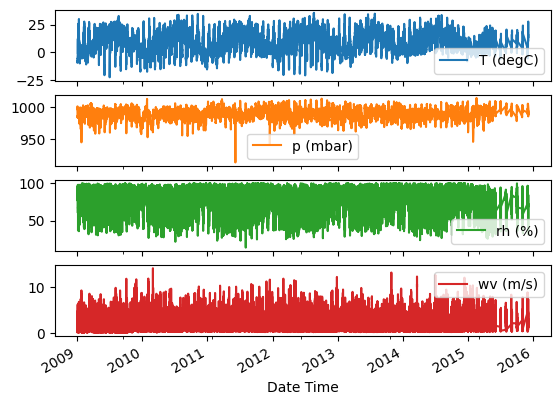

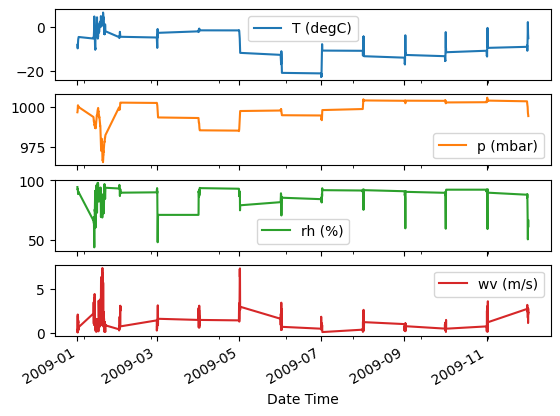

In [9]:

plot_cols = ['T (degC)', 'p (mbar)', 'rh (%)', 'wv (m/s)']
plot_features = df[plot_cols]
plot_features.index = df['Date Time']
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:500]
plot_features.index = pd.DatetimeIndex(df['Date Time'][:500])
_ = plot_features.plot(subplots=True)


Data looks good except fo values after 2015, where there is clearly an anomaly.

In [10]:
# Let's investigate deeper
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),56072.0,988.832928,8.350194,913.60,983.8100,989.240,994.3100,1013.91
T (degC),56072.0,8.987746,8.440986,-22.76,2.8800,8.970,15.0700,35.65
Tpot (K),56072.0,283.059875,8.518036,250.85,277.0000,283.100,289.1300,309.73
Tdew (degC),56072.0,4.551409,6.830787,-24.80,-0.1200,4.745,9.7325,23.06
rh (%),56072.0,76.208224,16.498261,13.88,65.4975,79.500,89.6000,100.00
VPmax (mbar),56072.0,13.170791,7.479040,0.97,7.5200,11.470,17.1600,58.34
VPact (mbar),56072.0,9.297106,4.150333,0.81,6.0500,8.575,12.0800,28.25
VPdef (mbar),56072.0,3.873606,4.673326,0.00,0.8200,2.090,5.1000,41.78
wv (m/s),56072.0,2.149853,1.542047,0.00,1.0100,1.790,2.8900,14.01
max. wv (m/s),56072.0,3.558251,2.337514,0.00,1.8000,3.000,4.7600,23.50


In [11]:
# We need to preprocess the variables that are expressed in radians

wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

In [12]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),Wx,Wy,max Wx,max Wy
0,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,-0.204862,-0.046168,-0.614587,-0.138503
1,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,-0.245971,-0.044701,-0.619848,-0.112645
2,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,-0.175527,0.039879,-0.614344,0.139576
3,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,-0.050000,-0.086603,-0.190000,-0.329090
4,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,-0.368202,0.156292,-0.810044,0.343843


In [13]:
timestamp_s = df['Date Time'].map(pd.Timestamp.timestamp)

In [14]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

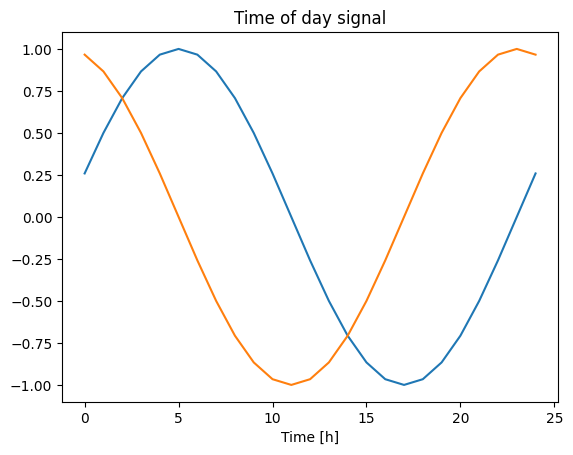

In [15]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of year signal')

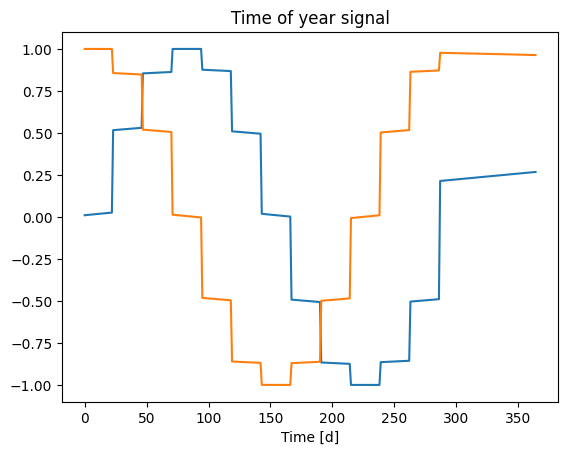

In [16]:
plt.plot(np.array(df['Year sin'])[:365])
plt.plot(np.array(df['Year cos'])[:365])
plt.xlabel('Time [d]')
plt.title('Time of year signal')

In [17]:
df.tail()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
56067,2015-05-24 14:00:00,991.94,17.16,290.99,9.83,62.00,19.60,12.15,7.45,2.520849,1.626445,3.865301,2.493882,-0.500000,-8.660254e-01,0.621029,-0.783787
56068,2015-05-24 15:00:00,991.52,17.77,291.64,9.29,57.52,20.37,11.72,8.66,-0.143727,0.868184,-0.372383,2.249385,-0.707107,-7.071068e-01,0.620467,-0.784232
56069,2015-05-24 16:00:00,990.96,19.40,293.32,9.07,51.17,22.56,11.55,11.02,-0.495154,0.373125,-1.086144,0.818468,-0.866025,-5.000000e-01,0.619905,-0.784677
56070,2015-05-24 17:00:00,990.56,19.03,292.98,9.04,52.25,22.05,11.52,10.53,-0.755076,-0.232292,-1.299879,-0.399895,-0.965926,-2.588190e-01,0.619343,-0.785121
56071,2015-05-24 18:00:00,990.23,18.46,292.44,8.97,53.89,21.28,11.47,9.81,0.724710,0.840771,1.710577,1.984522,-1.000000,-2.947092e-12,0.618780,-0.785565


In [18]:
df = df[df['Date Time'].dt.year != 2015] # Remove all rows whose year is 2015
df.reset_index(drop=True, inplace=True) # Reset the index of the resulting dataframe

In [19]:
# Then, set Date Time as the index variable
df.tail() # We take a look

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
52616,2014-12-31 19:00:00,1006.20,2.27,274.94,1.96,97.8,7.19,7.04,0.16,-0.242173,0.414430,-0.645795,1.105146,-0.965926,0.258819,-0.002079,0.999998
52617,2014-12-31 20:00:00,1006.28,2.14,274.81,1.89,98.2,7.13,7.00,0.13,-0.332780,0.593007,-0.822163,1.465076,-0.866025,0.500000,-0.001362,0.999999
52618,2014-12-31 21:00:00,1006.69,1.96,274.60,1.72,98.3,7.04,6.92,0.12,-0.550837,0.381417,-1.282545,0.888076,-0.707107,0.707107,-0.000645,1.000000
52619,2014-12-31 22:00:00,1006.92,1.94,274.56,1.75,98.6,7.03,6.93,0.10,-0.452571,0.547064,-1.147363,1.386924,-0.500000,0.866025,0.000072,1.000000
52620,2014-12-31 23:00:00,1007.11,2.18,274.78,2.01,98.8,7.15,7.06,0.09,-0.271231,0.221210,-0.666452,0.543545,-0.258819,0.965926,0.000788,1.000000


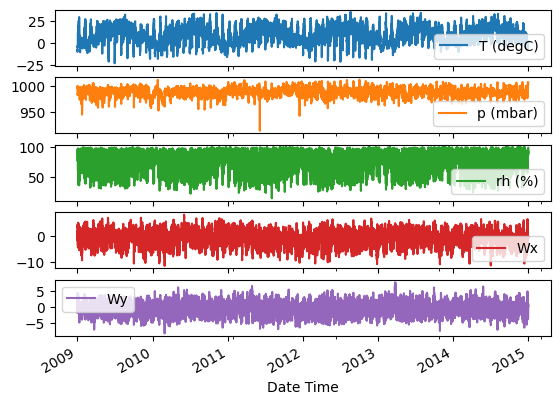

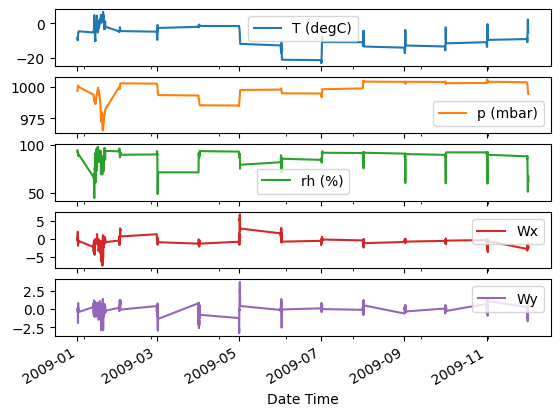

In [20]:
plot_cols = ['T (degC)', 'p (mbar)', 'rh (%)', 'Wx', 'Wy']
plot_features = df[plot_cols]
plot_features.index = df['Date Time']
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:500]
plot_features.index = pd.DatetimeIndex(df['Date Time'][:500])
_ = plot_features.plot(subplots=True)

The trimming worked, so we are now ready to create columns containing the prior timepoints:

In [21]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):]

num_features = df.shape[1]

In [22]:
train_df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
1,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
2,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
3,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
4,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917


In [23]:
val_df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
42096,2013-10-20 01:30:00,987.36,14.46,288.67,10.89,79.1,16.49,13.05,3.45,-1.088430,1.159060,-1.834586,1.953636,0.382683,0.923880,-0.948685,0.316223
42097,2013-10-20 02:30:00,987.35,14.27,288.48,10.93,80.3,16.29,13.08,3.21,-1.455654,-0.878107,-1.883788,-1.136373,0.608761,0.793353,-0.948458,0.316903
42098,2013-10-20 03:30:00,987.61,13.96,288.15,11.03,82.5,15.97,13.17,2.79,-0.859674,0.230349,-2.009126,0.538344,0.793353,0.608761,-0.948231,0.317583
42099,2013-10-20 04:30:00,987.66,15.90,290.09,12.38,79.6,18.09,14.40,3.69,-2.657367,-1.615704,-4.144125,-2.519668,0.923880,0.382683,-0.948003,0.318262
42100,2013-10-20 05:30:00,987.67,15.04,289.22,12.51,84.8,17.12,14.52,2.60,-2.865470,-1.735390,-4.285375,-2.595315,0.991445,0.130526,-0.947774,0.318942


In [24]:
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
train_mean = train_df[numeric_cols].mean(numeric_only=True)
train_std = train_df[numeric_cols].std(numeric_only=True)

train_df[numeric_cols] = (train_df[numeric_cols] - train_mean) / train_std
val_df[numeric_cols] = (val_df[numeric_cols] - train_mean) / train_std

C:\Users\usuario\AppData\Local\Temp\ipykernel_9152\1788790050.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[numeric_cols] = (train_df[numeric_cols] - train_mean) / train_std
C:\Users\usuario\AppData\Local\Temp\ipykernel_9152\1788790050.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[numeric_cols] = (val_df[numeric_cols] - train_mean) / train_std


In [25]:
train_df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,2009-01-01 01:00:00,0.933933,-1.930717,-1.989975,-1.855824,1.116628,-1.289666,-1.459553,-0.788278,0.181904,0.222705,0.099683,0.219956,0.366030,1.365974,-0.006048,1.449683
1,2009-01-01 02:00:00,0.948382,-2.024689,-2.084404,-1.994185,1.044124,-1.316755,-1.516124,-0.784135,0.161361,0.223641,0.097991,0.229785,0.707109,1.224696,-0.005038,1.449672
2,2009-01-01 03:00:00,0.974873,-2.016763,-2.078783,-1.978812,1.062250,-1.315465,-1.509053,-0.786206,0.196563,0.277578,0.099761,0.325662,1.000000,0.999954,-0.004028,1.449661
3,2009-01-01 04:00:00,0.992935,-2.043936,-2.106887,-2.029125,1.007872,-1.323204,-1.527910,-0.779993,0.259291,0.196920,0.236239,0.147509,1.224743,0.707066,-0.003018,1.449649
4,2009-01-01 05:00:00,1.049529,-2.109603,-2.176584,-2.117173,0.983704,-1.339974,-1.560910,-0.779993,0.100280,0.351816,0.036820,0.403309,1.366022,0.365990,-0.002007,1.449636


In [26]:
val_df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
42096,2013-10-20 01:30:00,-0.166644,0.617844,0.628177,0.893231,0.192197,0.407899,0.876383,-0.113041,-0.259630,0.991289,-0.292694,1.015235,0.541199,1.306512,-1.357294,0.478819
42097,2013-10-20 02:30:00,-0.167848,0.596332,0.606818,0.898821,0.264702,0.382100,0.883455,-0.162752,-0.443138,-0.307829,-0.308518,-0.159361,0.860919,1.121923,-1.356975,0.479785
42098,2013-10-20 03:30:00,-0.136541,0.561235,0.569721,0.912797,0.397626,0.340822,0.904669,-0.249745,-0.145317,0.399042,-0.348830,0.477244,1.121970,0.860875,-1.356654,0.480750
42099,2013-10-20 04:30:00,-0.130520,0.780880,0.787807,1.101472,0.222407,0.614289,1.194598,-0.063330,-1.043654,-0.778200,-1.035489,-0.685189,1.306560,0.541158,-1.356333,0.481715
42100,2013-10-20 05:30:00,-0.129316,0.683511,0.690005,1.119640,0.536593,0.489165,1.222884,-0.289100,-1.147646,-0.854525,-1.080918,-0.713945,1.402111,0.184559,-1.356011,0.482679


In [27]:
# Now we MinMax scale every column except the first column
scaler = MinMaxScaler(feature_range=(-1, 1)) # This is the scaler we will use to scale every column to values from 0 to 1
train_df = pd.DataFrame(scaler.fit_transform(train_df.iloc[:, 1:]), columns=train_df.columns[1:]) # Take all columns except the first


# Now we MinMax scale every column except the first column
scaler = MinMaxScaler(feature_range=(-1, 1)) # This is the scaler we will use to scale every column to values from 0 to 1
val_df = pd.DataFrame(scaler.fit_transform(val_df.iloc[:, 1:]), columns=val_df.columns[1:]) # Take all columns except the first


In [28]:
train_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,0.670866,-0.496319,-0.506454,-0.330547,0.869949,-0.917727,-0.830175,-0.990905,0.135604,0.027999,0.205966,0.010418,0.258819,0.965926,0.010049,0.999950
1,0.673284,-0.524739,-0.534986,-0.371918,0.842081,-0.925048,-0.847668,-0.989947,0.131399,0.028183,0.205632,0.012190,0.500000,0.866025,0.010766,0.999942
2,0.677718,-0.522342,-0.533288,-0.367321,0.849048,-0.924699,-0.845481,-0.990426,0.138605,0.038750,0.205981,0.029474,0.707107,0.707107,0.011483,0.999934
3,0.680742,-0.530560,-0.541780,-0.382365,0.828147,-0.926791,-0.851312,-0.988990,0.151447,0.022948,0.232877,-0.002642,0.866025,0.500000,0.012199,0.999926
4,0.690215,-0.550419,-0.562840,-0.408692,0.818857,-0.931323,-0.861516,-0.988990,0.118894,0.053294,0.193577,0.043472,0.965926,0.258819,0.012916,0.999917


In [29]:
val_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,0.087719,0.118349,0.117362,0.404948,0.451659,-0.449141,-0.019553,-0.819419,0.133799,0.246318,0.063859,0.284864,0.382683,0.923880,-0.948685,0.316223
1,0.087297,0.109633,0.108600,0.407454,0.483143,-0.457230,-0.016760,-0.831981,0.092473,-0.046815,0.060318,-0.004249,0.608761,0.793353,-0.948458,0.316903
2,0.098288,0.095413,0.093383,0.413718,0.540863,-0.470172,-0.008380,-0.853965,0.159543,0.112683,0.051300,0.152444,0.793353,0.608761,-0.948231,0.317583
3,0.100402,0.184404,0.182845,0.498277,0.464778,-0.384429,0.106145,-0.806857,-0.042765,-0.152950,-0.102319,-0.133675,0.923880,0.382683,-0.948003,0.318262
4,0.100824,0.144954,0.142725,0.506420,0.601207,-0.423660,0.117318,-0.863910,-0.066185,-0.170172,-0.112482,-0.140753,0.991445,0.130526,-0.947774,0.318942


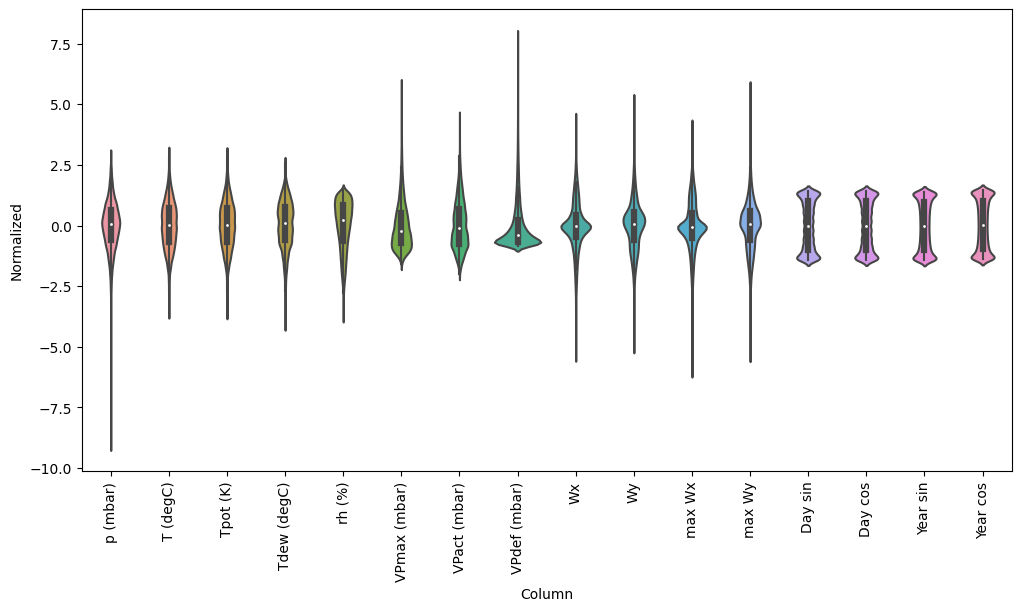

In [30]:
# Calculate standardized values for all columns except the first
df_std = (df.iloc[:,1:] - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

# Plot violin plot
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.columns[1:], rotation=90)

In [31]:
column_names = train_df.columns.tolist()
print(column_names)

['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'Wx', 'Wy', 'max Wx', 'max Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']


In [32]:
def prepare_dataframe_for_lstm(df, n_steps):
   
    for i in range(1, n_steps+1):
        df[f'p (mbar)(t-{i})'] = df['p (mbar)'].shift(i)
    
    for i in range(1, n_steps+1):
        df[f'T (degC)(t-{i})'] = df['T (degC)'].shift(i)

    for i in range(1, n_steps+1):
        df[f'rh (%)(t-{i})'] = df['rh (%)'].shift(i)

    for i in range(1, n_steps+1):
        df[f'Tpot (K)(t-{i})'] = df['Tpot (K)'].shift(i)

    for i in range(1, n_steps+1):
        df[f'Tdew (degC)(t-{i})'] = df['Tdew (degC)'].shift(i)
        
    for i in range(1, n_steps+1):
        df[f'VPmax (mbar)(t-{i})'] = df['VPmax (mbar)'].shift(i)

    for i in range(1, n_steps+1):
        df[f'VPact (mbar)(t-{i})'] = df['VPact (mbar)'].shift(i)

    for i in range(1, n_steps+1):
        df[f'VPdef (mbar)(t-{i})'] = df['VPdef (mbar)'].shift(i)

    for i in range(1, n_steps+1):
        df[f'Wx(t-{i})'] = df['Wx'].shift(i)

    for i in range(1, n_steps+1):
        df[f'Wy(t-{i})'] = df['Wy'].shift(i)

    for i in range(1, n_steps+1):
        df[f'max Wx(t-{i})'] = df['max Wx'].shift(i)

    for i in range(1, n_steps+1):
        df[f'max Wy(t-{i})'] = df['max Wy'].shift(i)

    for i in range(1, n_steps+1):
        df[f'Day sin(t-{i})'] = df['Day sin'].shift(i)
        
    for i in range(1, n_steps+1):
        df[f'Day cos(t-{i})'] = df['Day cos'].shift(i)
        
    for i in range(1, n_steps+1):
        df[f'Year sin(t-{i})'] = df['Day sin'].shift(i)
        
    for i in range(1, n_steps+1):
        df[f'Year cos(t-{i})'] = df['Day cos'].shift(i)
   
    # Return the shifted dataframe
    return df

In [33]:
prepare_dataframe_for_lstm(train_df, n_steps=lookback)
prepare_dataframe_for_lstm(val_df, n_steps=lookback)

C:\Users\usuario\AppData\Local\Temp\ipykernel_9152\423097190.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Day sin(t-{i})'] = df['Day sin'].shift(i)
C:\Users\usuario\AppData\Local\Temp\ipykernel_9152\423097190.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Day sin(t-{i})'] = df['Day sin'].shift(i)
C:\Users\usuario\AppData\Local\Temp\ipykernel_9152\423097190.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),Wx,Wy,...,Year sin(t-7),Year sin(t-8),Year cos(t-1),Year cos(t-2),Year cos(t-3),Year cos(t-4),Year cos(t-5),Year cos(t-6),Year cos(t-7),Year cos(t-8)
0,0.087719,0.118349,0.117362,0.404948,0.451659,-0.449141,-0.019553,-0.819419,0.133799,0.246318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.087297,0.109633,0.108600,0.407454,0.483143,-0.457230,-0.016760,-0.831981,0.092473,-0.046815,...,NaN,NaN,9.238795e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.098288,0.095413,0.093383,0.413718,0.540863,-0.470172,-0.008380,-0.853965,0.159543,0.112683,...,NaN,NaN,7.933533e-01,9.238795e-01,NaN,NaN,NaN,NaN,NaN,NaN
3,0.100402,0.184404,0.182845,0.498277,0.464778,-0.384429,0.106145,-0.806857,-0.042765,-0.152950,...,NaN,NaN,6.087614e-01,7.933533e-01,9.238795e-01,NaN,NaN,NaN,NaN,NaN
4,0.100824,0.144954,0.142725,0.506420,0.601207,-0.423660,0.117318,-0.863910,-0.066185,-0.170172,...,NaN,NaN,3.826834e-01,6.087614e-01,7.933533e-01,9.238795e-01,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10520,0.884168,-0.440826,-0.515794,-0.154400,0.942280,-0.825278,-0.579143,-0.991625,0.229035,0.139171,...,8.192870e-12,2.588190e-01,-1.075618e-11,-2.588190e-01,-5.000000e-01,-7.071068e-01,-8.660254e-01,-0.965926,-1.000000,-0.965926
10521,0.887550,-0.446789,-0.521789,-0.158785,0.952774,-0.827705,-0.582868,-0.993195,0.218839,0.164867,...,-2.588190e-01,8.192870e-12,2.588190e-01,-1.075618e-11,-2.588190e-01,-5.000000e-01,-7.071068e-01,-0.866025,-0.965926,-1.000000
10522,0.904883,-0.455046,-0.531473,-0.169433,0.955398,-0.831345,-0.590317,-0.993719,0.194299,0.134421,...,-5.000000e-01,-2.588190e-01,5.000000e-01,2.588190e-01,-1.075618e-11,-2.588190e-01,-5.000000e-01,-0.707107,-0.866025,-0.965926
10523,0.914606,-0.455963,-0.533318,-0.167554,0.963269,-0.831749,-0.589385,-0.994766,0.205358,0.158256,...,-7.071068e-01,-5.000000e-01,7.071068e-01,5.000000e-01,2.588190e-01,-1.075618e-11,-2.588190e-01,-0.500000,-0.707107,-0.866025


That worked, but the problem is that columns are ordered from $t-1$ to $t-k$, which is the opposite direction we want. We want to feed the furthest timepoints first and end with the most recent timepoint. Moreover, as it stands, columns are ordered by feature, not by timepoint, so we need to fix these two things: 

In [34]:
# Define a list of timepoints to group by
timepoints = [f't-{i}' for i in range(lookback, 0, -1)]

# Group the shifted columns by timepoint
all_shifted_cols = []
for timepoint in timepoints:
    columns = [f'{col}({timepoint})' for col in ['p (mbar)', 'T (degC)', 'rh (%)', 'Wx', 'Wy', 
                                                 'Tpot (K)', 'Tdew (degC)', 
                                                 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 
                                                 'max Wx', 'max Wy', 'Day sin', 
                                                 'Day cos', 'Year sin', 'Year cos' ]] #'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)'
    all_shifted_cols.extend(columns)
    
# Concatenate the target columns and the grouped columns
target_cols = ['p (mbar)', 'T (degC)', 'rh (%)', 'Wx', 'Wy']
feature_cols = ['Tpot (K)', 'Tdew (degC)', 
                                                 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 
                                                 'max Wx', 'max Wy', 'Day sin', 
                                                 'Day cos', 'Year sin', 'Year cos'] # 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)'
all_cols = target_cols + feature_cols + all_shifted_cols

In [35]:
# Let us take a look at the final variable 'all_cols'
all_cols

['p (mbar)',
 'T (degC)',
 'rh (%)',
 'Wx',
 'Wy',
 'Tpot (K)',
 'Tdew (degC)',
 'VPmax (mbar)',
 'VPact (mbar)',
 'VPdef (mbar)',
 'max Wx',
 'max Wy',
 'Day sin',
 'Day cos',
 'Year sin',
 'Year cos',
 'p (mbar)(t-8)',
 'T (degC)(t-8)',
 'rh (%)(t-8)',
 'Wx(t-8)',
 'Wy(t-8)',
 'Tpot (K)(t-8)',
 'Tdew (degC)(t-8)',
 'VPmax (mbar)(t-8)',
 'VPact (mbar)(t-8)',
 'VPdef (mbar)(t-8)',
 'max Wx(t-8)',
 'max Wy(t-8)',
 'Day sin(t-8)',
 'Day cos(t-8)',
 'Year sin(t-8)',
 'Year cos(t-8)',
 'p (mbar)(t-7)',
 'T (degC)(t-7)',
 'rh (%)(t-7)',
 'Wx(t-7)',
 'Wy(t-7)',
 'Tpot (K)(t-7)',
 'Tdew (degC)(t-7)',
 'VPmax (mbar)(t-7)',
 'VPact (mbar)(t-7)',
 'VPdef (mbar)(t-7)',
 'max Wx(t-7)',
 'max Wy(t-7)',
 'Day sin(t-7)',
 'Day cos(t-7)',
 'Year sin(t-7)',
 'Year cos(t-7)',
 'p (mbar)(t-6)',
 'T (degC)(t-6)',
 'rh (%)(t-6)',
 'Wx(t-6)',
 'Wy(t-6)',
 'Tpot (K)(t-6)',
 'Tdew (degC)(t-6)',
 'VPmax (mbar)(t-6)',
 'VPact (mbar)(t-6)',
 'VPdef (mbar)(t-6)',
 'max Wx(t-6)',
 'max Wy(t-6)',
 'Day sin(t-6)',
 

Feature columns are now grouped by tiempoint and the direction of time has been flipped. Good progress, but now we must delete the custom features at timepoint $t$, as we are not allowed to use current timepoints.

In [36]:
# First we udpate the df
train_df = train_df[all_cols]
val_df = val_df[all_cols]

In [37]:
train_df.head()

,p (mbar),T (degC),rh (%),Wx,Wy,Tpot (K),Tdew (degC),VPmax (mbar),VPact (mbar),VPdef (mbar),...,Tdew (degC)(t-1),VPmax (mbar)(t-1),VPact (mbar)(t-1),VPdef (mbar)(t-1),max Wx(t-1),max Wy(t-1),Day sin(t-1),Day cos(t-1),Year sin(t-1),Year cos(t-1)
0,0.670866,-0.496319,0.869949,0.135604,0.027999,-0.506454,-0.330547,-0.917727,-0.830175,-0.990905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.673284,-0.524739,0.842081,0.131399,0.028183,-0.534986,-0.371918,-0.925048,-0.847668,-0.989947,...,-0.330547,-0.917727,-0.830175,-0.990905,0.205966,0.010418,0.258819,0.965926,0.258819,0.965926
2,0.677718,-0.522342,0.849048,0.138605,0.038750,-0.533288,-0.367321,-0.924699,-0.845481,-0.990426,...,-0.371918,-0.925048,-0.847668,-0.989947,0.205632,0.012190,0.500000,0.866025,0.500000,0.866025
3,0.680742,-0.530560,0.828147,0.151447,0.022948,-0.541780,-0.382365,-0.926791,-0.851312,-0.988990,...,-0.367321,-0.924699,-0.845481,-0.990426,0.205981,0.029474,0.707107,0.707107,0.707107,0.707107
4,0.690215,-0.550419,0.818857,0.118894,0.053294,-0.562840,-0.408692,-0.931323,-0.861516,-0.988990,...,-0.382365,-0.926791,-0.851312,-0.988990,0.232877,-0.002642,0.866025,0.500000,0.866025,0.500000


In [38]:
val_df.head()

,p (mbar),T (degC),rh (%),Wx,Wy,Tpot (K),Tdew (degC),VPmax (mbar),VPact (mbar),VPdef (mbar),...,Tdew (degC)(t-1),VPmax (mbar)(t-1),VPact (mbar)(t-1),VPdef (mbar)(t-1),max Wx(t-1),max Wy(t-1),Day sin(t-1),Day cos(t-1),Year sin(t-1),Year cos(t-1)
0,0.087719,0.118349,0.451659,0.133799,0.246318,0.117362,0.404948,-0.449141,-0.019553,-0.819419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.087297,0.109633,0.483143,0.092473,-0.046815,0.108600,0.407454,-0.457230,-0.016760,-0.831981,...,0.404948,-0.449141,-0.019553,-0.819419,0.063859,0.284864,0.382683,0.923880,0.382683,0.923880
2,0.098288,0.095413,0.540863,0.159543,0.112683,0.093383,0.413718,-0.470172,-0.008380,-0.853965,...,0.407454,-0.457230,-0.016760,-0.831981,0.060318,-0.004249,0.608761,0.793353,0.608761,0.793353
3,0.100402,0.184404,0.464778,-0.042765,-0.152950,0.182845,0.498277,-0.384429,0.106145,-0.806857,...,0.413718,-0.470172,-0.008380,-0.853965,0.051300,0.152444,0.793353,0.608761,0.793353,0.608761
4,0.100824,0.144954,0.601207,-0.066185,-0.170172,0.142725,0.506420,-0.423660,0.117318,-0.863910,...,0.498277,-0.384429,0.106145,-0.806857,-0.102319,-0.133675,0.923880,0.382683,0.923880,0.382683


In [39]:
print(train_df.columns[:60])

Index(['p (mbar)', 'T (degC)', 'rh (%)', 'Wx', 'Wy', 'Tpot (K)', 'Tdew (degC)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'max Wx', 'max Wy',
       'Day sin', 'Day cos', 'Year sin', 'Year cos', 'p (mbar)(t-8)',
       'T (degC)(t-8)', 'rh (%)(t-8)', 'Wx(t-8)', 'Wy(t-8)', 'Tpot (K)(t-8)',
       'Tdew (degC)(t-8)', 'VPmax (mbar)(t-8)', 'VPact (mbar)(t-8)',
       'VPdef (mbar)(t-8)', 'max Wx(t-8)', 'max Wy(t-8)', 'Day sin(t-8)',
       'Day cos(t-8)', 'Year sin(t-8)', 'Year cos(t-8)', 'p (mbar)(t-7)',
       'T (degC)(t-7)', 'rh (%)(t-7)', 'Wx(t-7)', 'Wy(t-7)', 'Tpot (K)(t-7)',
       'Tdew (degC)(t-7)', 'VPmax (mbar)(t-7)', 'VPact (mbar)(t-7)',
       'VPdef (mbar)(t-7)', 'max Wx(t-7)', 'max Wy(t-7)', 'Day sin(t-7)',
       'Day cos(t-7)', 'Year sin(t-7)', 'Year cos(t-7)', 'p (mbar)(t-6)',
       'T (degC)(t-6)', 'rh (%)(t-6)', 'Wx(t-6)', 'Wy(t-6)', 'Tpot (K)(t-6)',
       'Tdew (degC)(t-6)', 'VPmax (mbar)(t-6)', 'VPact (mbar)(t-6)',
       'VPdef (mbar)(t-6)', 'max Wx(t-

In [40]:
print(val_df.columns[:60])

Index(['p (mbar)', 'T (degC)', 'rh (%)', 'Wx', 'Wy', 'Tpot (K)', 'Tdew (degC)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'max Wx', 'max Wy',
       'Day sin', 'Day cos', 'Year sin', 'Year cos', 'p (mbar)(t-8)',
       'T (degC)(t-8)', 'rh (%)(t-8)', 'Wx(t-8)', 'Wy(t-8)', 'Tpot (K)(t-8)',
       'Tdew (degC)(t-8)', 'VPmax (mbar)(t-8)', 'VPact (mbar)(t-8)',
       'VPdef (mbar)(t-8)', 'max Wx(t-8)', 'max Wy(t-8)', 'Day sin(t-8)',
       'Day cos(t-8)', 'Year sin(t-8)', 'Year cos(t-8)', 'p (mbar)(t-7)',
       'T (degC)(t-7)', 'rh (%)(t-7)', 'Wx(t-7)', 'Wy(t-7)', 'Tpot (K)(t-7)',
       'Tdew (degC)(t-7)', 'VPmax (mbar)(t-7)', 'VPact (mbar)(t-7)',
       'VPdef (mbar)(t-7)', 'max Wx(t-7)', 'max Wy(t-7)', 'Day sin(t-7)',
       'Day cos(t-7)', 'Year sin(t-7)', 'Year cos(t-7)', 'p (mbar)(t-6)',
       'T (degC)(t-6)', 'rh (%)(t-6)', 'Wx(t-6)', 'Wy(t-6)', 'Tpot (K)(t-6)',
       'Tdew (degC)(t-6)', 'VPmax (mbar)(t-6)', 'VPact (mbar)(t-6)',
       'VPdef (mbar)(t-6)', 'max Wx(t-

In [41]:
shifted_df = train_df.drop(train_df.columns[5:16], axis=1) # We delete the custom features at timpoint t
shifted_df_val = val_df.drop(val_df.columns[5:16], axis=1) # We delete the custom features at timpoint t

In [42]:
shifted_df.head()
shifted_df_val.head()

,p (mbar),T (degC),rh (%),Wx,Wy,p (mbar)(t-8),T (degC)(t-8),rh (%)(t-8),Wx(t-8),Wy(t-8),...,Tdew (degC)(t-1),VPmax (mbar)(t-1),VPact (mbar)(t-1),VPdef (mbar)(t-1),max Wx(t-1),max Wy(t-1),Day sin(t-1),Day cos(t-1),Year sin(t-1),Year cos(t-1)
0,0.087719,0.118349,0.451659,0.133799,0.246318,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.087297,0.109633,0.483143,0.092473,-0.046815,NaN,NaN,NaN,NaN,NaN,...,0.404948,-0.449141,-0.019553,-0.819419,0.063859,0.284864,0.382683,0.923880,0.382683,0.923880
2,0.098288,0.095413,0.540863,0.159543,0.112683,NaN,NaN,NaN,NaN,NaN,...,0.407454,-0.457230,-0.016760,-0.831981,0.060318,-0.004249,0.608761,0.793353,0.608761,0.793353
3,0.100402,0.184404,0.464778,-0.042765,-0.152950,NaN,NaN,NaN,NaN,NaN,...,0.413718,-0.470172,-0.008380,-0.853965,0.051300,0.152444,0.793353,0.608761,0.793353,0.608761
4,0.100824,0.144954,0.601207,-0.066185,-0.170172,NaN,NaN,NaN,NaN,NaN,...,0.498277,-0.384429,0.106145,-0.806857,-0.102319,-0.133675,0.923880,0.382683,0.923880,0.382683


In [43]:
shifted_df = shifted_df.dropna()
shifted_df_val = shifted_df_val.dropna()

In [44]:
shifted_df.head()

,p (mbar),T (degC),rh (%),Wx,Wy,p (mbar)(t-8),T (degC)(t-8),rh (%)(t-8),Wx(t-8),Wy(t-8),...,Tdew (degC)(t-1),VPmax (mbar)(t-1),VPact (mbar)(t-1),VPdef (mbar)(t-1),max Wx(t-1),max Wy(t-1),Day sin(t-1),Day cos(t-1),Year sin(t-1),Year cos(t-1)
8,0.735161,-0.482965,0.795634,0.124358,0.017717,0.670866,-0.496319,0.869949,0.135604,0.027999,...,-0.341830,-0.918424,-0.835277,-0.988511,0.179160,-0.027867,8.660254e-01,-0.500000,8.660254e-01,-0.500000
9,0.746851,-0.461736,0.804923,0.213567,-0.133479,0.673284,-0.524739,0.842081,0.131399,0.028183,...,-0.333055,-0.914241,-0.830904,-0.985639,0.207949,0.003597,7.071068e-01,-0.707107,7.071068e-01,-0.707107
10,0.758944,-0.474405,0.784022,0.155198,-0.204854,0.677718,-0.522342,0.849048,0.138605,0.038750,...,-0.305056,-0.908314,-0.818513,-0.985639,0.317992,-0.169885,5.000000e-01,-0.866025,5.000000e-01,-0.866025
11,0.747455,-0.455915,0.758477,-0.031117,0.016131,0.680742,-0.530560,0.828147,0.151447,0.022948,...,-0.325533,-0.911801,-0.827988,-0.984203,0.243424,-0.211706,2.588190e-01,-0.965926,2.588190e-01,-0.965926
12,0.742014,-0.422359,0.735253,0.098723,0.024719,0.690215,-0.550419,0.818857,0.118894,0.053294,...,-0.309653,-0.906920,-0.820700,-0.981809,0.078716,0.006082,6.903299e-12,-1.000000,6.903299e-12,-1.000000


In [45]:
shifted_df_val.head()

,p (mbar),T (degC),rh (%),Wx,Wy,p (mbar)(t-8),T (degC)(t-8),rh (%)(t-8),Wx(t-8),Wy(t-8),...,Tdew (degC)(t-1),VPmax (mbar)(t-1),VPact (mbar)(t-1),VPdef (mbar)(t-1),max Wx(t-1),max Wy(t-1),Day sin(t-1),Day cos(t-1),Year sin(t-1),Year cos(t-1)
8,0.149440,0.222477,0.477896,-0.091436,-0.191852,0.087719,0.118349,0.451659,0.133799,0.246318,...,0.473223,-0.477452,0.070764,-0.907354,-0.015788,0.261613,0.793353,-0.608761,0.793353,-0.608761
9,0.156627,0.250917,0.386068,-0.354008,-0.163510,0.087297,0.109633,0.483143,0.092473,-0.046815,...,0.555277,-0.344388,0.188082,-0.801099,-0.237115,-0.241596,0.608761,-0.793353,0.608761,-0.793353
10,0.149863,0.262844,0.365079,-0.187159,-0.019420,0.098288,0.095413,0.540863,0.159543,0.112683,...,0.549640,-0.313650,0.180633,-0.757132,-0.307691,-0.101872,0.382683,-0.923880,0.382683,-0.923880
11,0.125343,0.228440,0.451659,-0.014054,0.202624,0.100402,0.184404,0.464778,-0.042765,-0.152950,...,0.555277,-0.300303,0.189013,-0.744569,-0.235096,0.004270,0.130526,-0.991445,0.130526,-0.991445
12,0.132107,0.231651,0.456907,0.032462,0.089032,0.100824,0.144954,0.601207,-0.066185,-0.170172,...,0.550893,-0.337917,0.182495,-0.789584,-0.088829,0.233896,-0.130526,-0.991445,-0.130526,-0.991445


That looks good. The first four columns contain our targets at timepoint $t$. Then, the other columns contain the $t-k$ ... $t-1$ values for each target variable. We're not done yet, though. Now we can turn this data into a Numpy array:

In [46]:
# We convert to numpy and print
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_val_as_np = shifted_df_val.to_numpy()
print(shifted_df_as_np)
print(shifted_df_val_as_np)

[[ 0.73516074 -0.48296525  0.795634   ... -0.5         0.8660254
  -0.5       ]
 [ 0.74685075 -0.461736    0.80492336 ... -0.70710678  0.70710678
  -0.70710678]
 [ 0.75894387 -0.47440507  0.78402229 ... -0.8660254   0.5
  -0.8660254 ]
 ...
 [ 0.48503477  0.24225304  0.46586159 ...  0.79335334 -0.60876143
   0.79335334]
 [ 0.47939131  0.25184044  0.48444032 ...  0.92387953 -0.38268343
   0.92387953]
 [ 0.48261614  0.27580894  0.47515095 ...  0.99144486 -0.13052619
   0.99144486]]
[[ 0.14943986  0.22247706  0.47789584 ... -0.60876143  0.79335334
  -0.60876143]
 [ 0.15662651  0.25091743  0.38606848 ... -0.79335334  0.60876143
  -0.79335334]
 [ 0.14986261  0.26284404  0.36507937 ... -0.92387953  0.38268343
  -0.92387953]
 ...
 [ 0.90488269 -0.45504587  0.95539814 ...  0.5        -0.8660254
   0.5       ]
 [ 0.91460579 -0.4559633   0.96326905 ...  0.70710678 -0.70710678
   0.70710678]
 [ 0.92263792 -0.44495413  0.96851633 ...  0.8660254  -0.5
   0.8660254 ]]


In [47]:
# Let's take a look at the shape
print(shifted_df_as_np.shape)
print(shifted_df_val_as_np.shape)

(42088, 133)
(10517, 133)


We have quite a few rows and 28 columns. That is, 4 targets in the first 4 columns plus $4*k$ columns which equals 24 in this case because we set $k$ to be equal to 6. Now we need to divide this into our `X` and `y` variables. For `X` we will take all columns but the first 4 and for `y` we will take just the first 4:

In [48]:
# We define X and y as mentioned
X_train = shifted_df_as_np[:, 5:]
y_train = shifted_df_as_np[:, :5]

X_test = shifted_df_val_as_np[:, 5:]
y_test = shifted_df_val_as_np[:, :5]
# Print the shapes to inspect them
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(42088, 128) (42088, 5)
(10517, 128) (10517, 5)


The dimension match perfectly for Xs and their respective ys. Now we can reshape the data in the following way:

In [49]:
# We essentially want number_of_samples, lookback_size(k), and number of features for the Xs
X_train = X_train.reshape(-1, lookback, 16)
X_test = X_test.reshape(-1, lookback, 16)
#X_test = X_test.reshape(-1, lookback, 7)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(42088, 8, 16) (10517, 8, 16)
(42088, 5) (10517, 5)


In [50]:
# Pytorch only deals with tensors, so we need to convert these last np arrays into torch floats:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

print(X_train.shape, y_train.shape) #, y_train.shape, y_test.shape) # Inspect the shape once again

torch.Size([42088, 8, 16]) torch.Size([42088, 5])


Everything looks good now. The next steps are easy since we've already done a lot of pre-processing legwork. Essentially, we just need to pass our Xs and ys into a Dataset class and then wrap the Dataset class into a DataLoader object that will batch our data nicely:

In [51]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset): # Nothing fancy here, just making sure we can access length and individual items
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [52]:
from torch.utils.data import DataLoader

batch_size = batch_size # We will try batch_size values of 64 and 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [53]:
# One last sanity check. Let us make sure we can retrieve batches and that they have the right size: 
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([64, 8, 16]) torch.Size([64, 5])


Great, the first dimension of both X and y now correspond to batch length, not number of n_rows * n_columns. This means that the batching has worked well. Let's verify the same for the validation dataloader (here defined as test_loader): 

In [54]:
# One last sanity check. Let us make sure we can retrieve batches and that they have the right size: 
for _, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([64, 8, 16]) torch.Size([64, 5])


All good. At long last, we can now define our model class. This next part is a bit finicky in standard PyTorch, compared to Lightning or even TensorFlow, as we need to initialize the hidden state `h0` cell state `c0`. That said, since our model is not too complex, we can live with it:

In [55]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        
        # Store the input parameters as instance variables
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        # Initialize an LSTM layer with the given input size, hidden size, and number of stacked layers. Set batch_first to True.
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
               
        # Initialize a linear layer to map the hidden state output from the LSTM to a scalar output. The output of this linear layer will be the 4 predicted values.
        self.fc1 = nn.Linear(hidden_size, 5)
    
    def forward(self, x):
        h_n = torch.zeros(self.num_stacked_layers, x.size(0), self.hidden_size)
        c_n = torch.zeros(self.num_stacked_layers, x.size(0), self.hidden_size)
        h_n = h_n.to(device)
        c_n = c_n.to(device)
        # Pass the input through the LSTM layer
        output, (h_n, c_n) = self.lstm(x)

        # Pass the LSTM output through the linear layer
        output = (self.fc1(output[:, -1, :]))
        
        return output

# Instantiate a new LSTM model with input size 16, hidden size 30, and 3 stacked LSTM layers (really these should be called LSTM cells, but I don't get to name things).
model = LSTM(16, 30, 3)

# Move the model to the device specified by the 'device' variable
model.to(device)

# Print the model
print(model)

LSTM(
  (lstm): LSTM(16, 30, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=30, out_features=5, bias=True)
)


Next we will define a standard training loop as a function called `train_and_validate` which will take number of epochs as input:

In [56]:
from sklearn.metrics import r2_score, mean_absolute_error

def train_and_validate(num_epochs):
    for epoch in range(num_epochs):
        # Training
        train_loss = 0.0
        train_r2 = 0.0
        train_mae_epoch = np.zeros((5,))
        train_r2_epoch = np.zeros((5,))
        model.train()
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_r2 += r2_score(y_batch.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
            train_mae_epoch += mean_absolute_error(y_batch.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), multioutput='raw_values')
            train_r2_epoch += r2_score(y_batch.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), multioutput='raw_values')

        # Validation
        val_loss = 0.0
        val_r2 = 0.0
        val_mae_epoch = np.zeros((5,))
        val_r2_epoch = np.zeros((5,))
        model.eval()
        with torch.no_grad():
            for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = loss_function(y_pred, y_batch)
                val_loss += loss.item()
                val_r2 += r2_score(y_batch.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
                val_mae_epoch += mean_absolute_error(y_batch.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), multioutput='raw_values')
                val_r2_epoch += r2_score(y_batch.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), multioutput='raw_values')

        # Average metrics
        train_loss /= len(train_loader)
        val_loss /= len(test_loader)
        train_r2 /= len(train_loader)
        val_r2 /= len(test_loader)
        train_mae_epoch /= len(train_loader)
        val_mae_epoch /= len(test_loader)
        train_r2_epoch /= len(train_loader)
        val_r2_epoch /= len(test_loader)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_r2s.append(train_r2)
        val_r2s.append(val_r2)
        train_mae_ind.append(train_mae_epoch)
        val_mae_ind.append(val_mae_epoch)
        train_r2_ind.append(train_r2_epoch)
        val_r2_ind.append(val_r2_epoch)
        
        # Print progress
        print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train R2: {train_r2:.4f}, Val R2: {val_r2:.4f}")
        print(f"Train individual target MAEs: {train_mae_epoch}")
        print(f"Val individual target MAEs: {val_mae_epoch}")
        print(f"Train individual target R2s: {train_r2_epoch}") 
        print(f"Val individual target R2s: {val_r2_epoch}")
        print('***************************************************')        
        
        model.train(True)

In [57]:
### We're ready to train ! ###
learning_rate = lr
loss_function = nn.L1Loss() 
num_epochs = 50
weight_decay = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_losses = []
val_losses = []
train_r2s = []
val_r2s = []

train_mae_ind = []
val_mae_ind = []
train_r2_ind = []
val_r2_ind = []

train_and_validate(num_epochs = num_epochs)

Epoch: 1/50, Train Loss: 0.0866, Val Loss: 0.0985, Train R2: 0.6429, Val R2: 0.7332
Train individual target MAEs: [0.07399818 0.047753   0.11342563 0.09465394 0.10298357]
Val individual target MAEs: [0.11856158 0.05941766 0.07817594 0.13627985 0.09982487]
Train individual target R2s: [0.49406244 0.92049732 0.77512598 0.54327271 0.48141187]
Val individual target R2s: [0.74272868 0.95127525 0.92487514 0.44755789 0.59974919]
***************************************************
Epoch: 2/50, Train Loss: 0.0512, Val Loss: 0.0870, Train R2: 0.8638, Val R2: 0.8104
Train individual target MAEs: [0.02030881 0.02179884 0.05983052 0.07255226 0.08152466]
Val individual target MAEs: [0.08803197 0.05924416 0.0980801  0.09590775 0.09374338]
Train individual target R2s: [0.9726753  0.989844   0.94481631 0.74116441 0.67059948]
Val individual target R2s: [0.87754195 0.95478939 0.90003941 0.67893944 0.64084239]
***************************************************
Epoch: 3/50, Train Loss: 0.0489, Val Loss: 0

Epoch: 19/50, Train Loss: 0.0455, Val Loss: 0.0817, Train R2: 0.8777, Val R2: 0.8251
Train individual target MAEs: [0.0067576  0.01728941 0.05638821 0.06925559 0.0777885 ]
Val individual target MAEs: [0.06228519 0.05089451 0.10649205 0.09858406 0.09044529]
Train individual target R2s: [0.99599412 0.99294118 0.94796648 0.75983446 0.69177874]
Val individual target R2s: [0.95317519 0.96715117 0.89440335 0.65801019 0.65252997]
***************************************************
Epoch: 20/50, Train Loss: 0.0455, Val Loss: 0.0817, Train R2: 0.8772, Val R2: 0.8195
Train individual target MAEs: [0.00665128 0.01739484 0.05623399 0.06934369 0.07764471]
Val individual target MAEs: [0.06923424 0.04582755 0.09842784 0.10512135 0.08975078]
Train individual target R2s: [0.99622954 0.99283134 0.94823473 0.75718546 0.69175822]
Val individual target R2s: [0.94417036 0.97237342 0.90395642 0.61840773 0.65871493]
***************************************************
Epoch: 21/50, Train Loss: 0.0454, Val Loss

Epoch: 37/50, Train Loss: 0.0448, Val Loss: 0.0818, Train R2: 0.8787, Val R2: 0.8308
Train individual target MAEs: [0.00580889 0.01678951 0.05535683 0.06888449 0.07701775]
Val individual target MAEs: [0.07211915 0.03693674 0.12156013 0.08754956 0.09087944]
Train individual target R2s: [0.99696188 0.99318121 0.94944876 0.75986395 0.69381301]
Val individual target R2s: [0.93869639 0.97979595 0.87174479 0.7151821  0.64867354]
***************************************************
Epoch: 38/50, Train Loss: 0.0448, Val Loss: 0.0824, Train R2: 0.8787, Val R2: 0.8269
Train individual target MAEs: [0.00604749 0.01685543 0.05521636 0.06889875 0.07703258]
Val individual target MAEs: [0.06610129 0.03841466 0.12527353 0.09223617 0.08972459]
Train individual target R2s: [0.99683732 0.99316879 0.94933803 0.75866864 0.69565778]
Val individual target R2s: [0.94863578 0.97863129 0.862722   0.69238253 0.65188744]
***************************************************
Epoch: 39/50, Train Loss: 0.0448, Val Loss

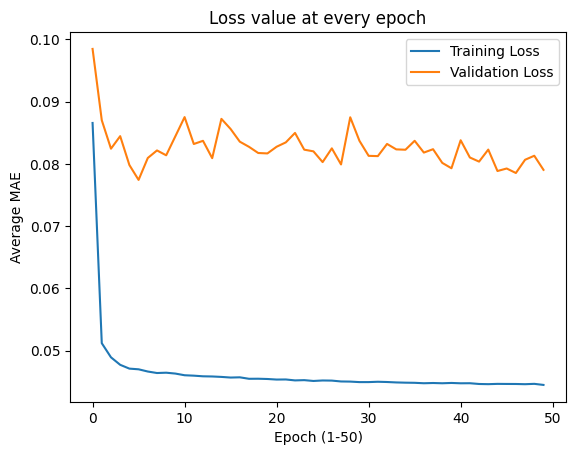

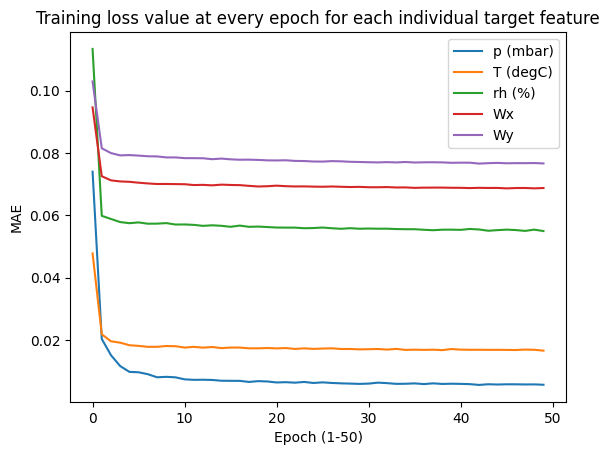

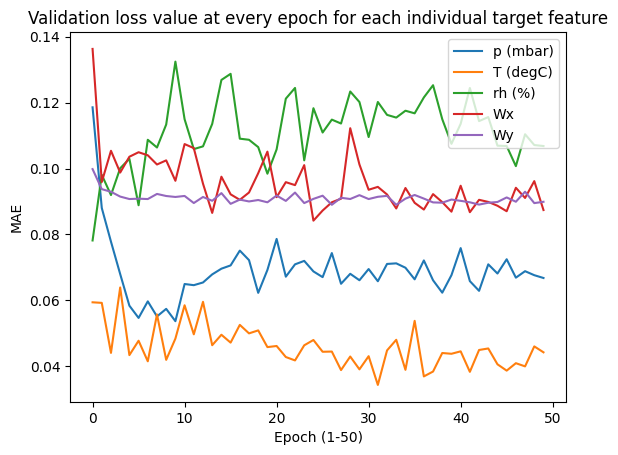

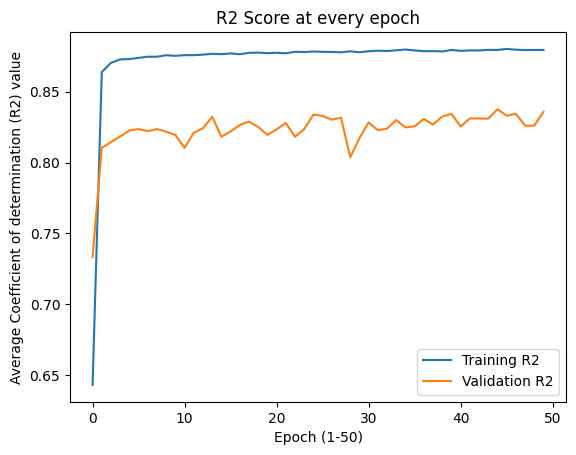

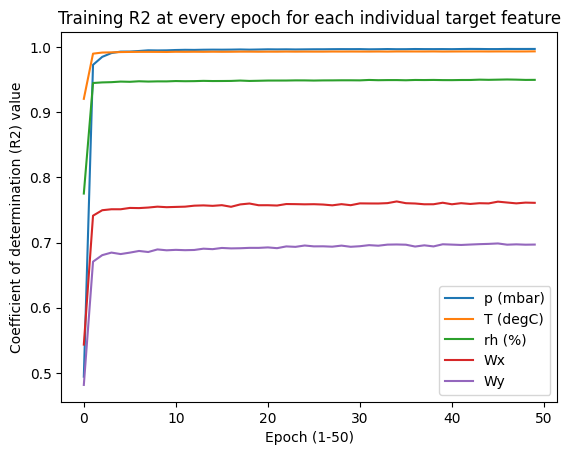

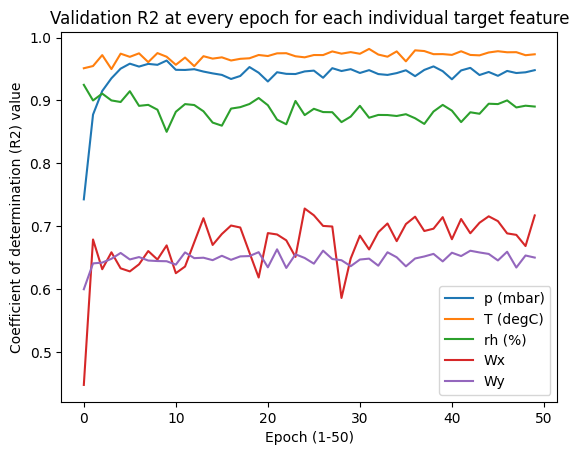

In [58]:
# We can now plot and save the results

labels = ['p (mbar)', 'T (degC)', 'rh (%)', 'Wx', 'Wy']

# plot the training and validation loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss value at every epoch')
plt.xlabel('Epoch (1-50)')
plt.ylabel('Average MAE')

# save the plot to a local directory
dir_path = dir_path
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
plt.savefig(os.path.join(dir_path, 'avg_loss.png'))

# plot the training loss curve for each target
plt.figure()
plt.plot(train_mae_ind, label='Training Loss')
plt.legend(labels = labels)
plt.title('Training loss value at every epoch for each individual target feature')
plt.xlabel('Epoch (1-50)')
plt.ylabel('MAE')

# save the plot to a local directory
plt.savefig(os.path.join(dir_path, 'ind_train_loss.png'))

# plot the validation loss curve for each target
plt.figure()
plt.plot(val_mae_ind, label='Validation Loss')
plt.legend(labels = labels)
plt.title('Validation loss value at every epoch for each individual target feature')
plt.xlabel('Epoch (1-50)')
plt.ylabel('MAE')

# save the plot to a local directory
plt.savefig(os.path.join(dir_path, 'ind_val_loss.png'))

# plot the training and validation R2 scores
plt.figure()
plt.plot(train_r2s, label='Training R2')
plt.plot(val_r2s, label='Validation R2')
plt.legend()
plt.title('R2 Score at every epoch')
plt.xlabel('Epoch (1-50)')
plt.ylabel('Average Coefficient of determination (R2) value')

# save the plot to a local directory
plt.savefig(os.path.join(dir_path, 'avg_r2.png'))

# plot the training loss curve for each target
plt.figure()
plt.plot(train_r2_ind, label='Training R2')
plt.legend(labels = labels)
plt.title('Training R2 at every epoch for each individual target feature')
plt.xlabel('Epoch (1-50)')
plt.ylabel('Coefficient of determination (R2) value')

# save the plot to a local directory
plt.savefig(os.path.join(dir_path, 'ind_train_r2.png'))

# plot the validation loss curve for each target
plt.figure()
plt.plot(val_r2_ind, label='Validation R2')
plt.legend(labels = labels)
plt.title('Validation R2 at every epoch for each individual target feature')
plt.xlabel('Epoch (1-50)')
plt.ylabel('Coefficient of determination (R2) value')

# save the plot to a local directory
plt.savefig(os.path.join(dir_path, 'ind_val_r2.png'))

In [59]:
# Find highest training and validation R2 values
highest_train_r2 = max(train_r2s)
highest_val_r2 = max(val_r2s)

# Find lowest training and validation losses
lowest_train_loss = min(train_losses)
lowest_val_loss = min(val_losses)

In [60]:
# Set directory path and filename for output file
output_dir = dir_path
output_filename = "results.txt"

# Create output directory if it doesn't already exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Open output file for writing
with open(os.path.join(output_dir, output_filename), 'w') as f:
    
    f.write("k was size: " + str(lookback) + "\n")
    f.write("batch was size: " + str(batch_size) + "\n")
    f.write("lr was size: " + str(lr) + "\n")
    
    # Write highest train R2 to file
    f.write("The highest train R2 was: " + str(highest_train_r2) + "\n")
    
    # Write highest val R2 to file
    f.write("The highest val R2 was: " + str(highest_val_r2) + "\n")
    
    # Write lowest train loss to file
    f.write("The lowest train loss was: " + str(lowest_train_loss) + "\n")
    
    # Write lowest val loss to file
    f.write("The lowest val loss was: " + str(lowest_val_loss) + "\n")
    
# Print confirmation message
print("Results saved to " + os.path.join(output_dir, output_filename))


Results saved to C:\Users\usuario\RecogniChess\HW4\Snapshots\LSTM2\BEST\results.txt


## Model Evaluation

In [61]:
# We import the test data
df2 = pd.read_csv(r"C:\Users\usuario\RecogniChess\HW4\weather_test.csv", header=0, parse_dates=[0])
print(df2.shape)

(14019, 15)


We have the same number of columns, but way less samples

In [62]:
# Let's drop any and all rows with NAs
df2.dropna(inplace=True)
print(df2.shape)

(14019, 15)


In [63]:
# Let's take a look
df2.tail()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
14014,2016-12-31 19:10:00,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
14015,2016-12-31 20:10:00,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
14016,2016-12-31 21:10:00,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7
14017,2016-12-31 22:10:00,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,0.35,0.68,216.7
14018,2016-12-31 23:10:00,1000.11,-3.93,269.23,-8.09,72.60,4.56,3.31,1.25,2.06,3.31,1292.41,0.56,1.00,202.6


In [64]:
# First, we will turn the first column into a Pandas datetime object
df2['Date Time'] = pd.to_datetime(df2['Date Time'])

In [65]:
# Let's take a look
df2.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2015-05-24 19:00:00,990.00,17.93,291.93,9.23,56.73,20.58,11.68,8.91,7.37,11.79,1179.50,1.58,2.16,34.37
1,2015-05-24 20:00:00,989.86,16.92,290.93,9.52,61.65,19.31,11.90,7.40,7.51,12.03,1183.33,0.23,0.60,20.89
2,2015-05-24 21:00:00,990.11,15.82,289.80,9.71,66.97,18.00,12.06,5.95,7.61,12.18,1188.07,0.26,0.52,252.00
3,2015-05-24 22:00:00,990.01,15.02,289.01,9.50,69.53,17.10,11.89,5.21,7.50,12.01,1191.32,1.22,1.88,218.50
4,2015-05-24 23:00:00,989.89,14.14,288.14,9.42,73.20,16.15,11.83,4.33,7.46,11.95,1194.85,1.43,1.96,218.00


In [66]:
df2 = df2.drop(columns=["sh (g/kg)", "H2OC (mmol/mol)", "rho (g/m**3)"])
df2.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),wv (m/s),max. wv (m/s),wd (deg)
0,2015-05-24 19:00:00,990.00,17.93,291.93,9.23,56.73,20.58,11.68,8.91,1.58,2.16,34.37
1,2015-05-24 20:00:00,989.86,16.92,290.93,9.52,61.65,19.31,11.90,7.40,0.23,0.60,20.89
2,2015-05-24 21:00:00,990.11,15.82,289.80,9.71,66.97,18.00,12.06,5.95,0.26,0.52,252.00
3,2015-05-24 22:00:00,990.01,15.02,289.01,9.50,69.53,17.10,11.89,5.21,1.22,1.88,218.50
4,2015-05-24 23:00:00,989.89,14.14,288.14,9.42,73.20,16.15,11.83,4.33,1.43,1.96,218.00


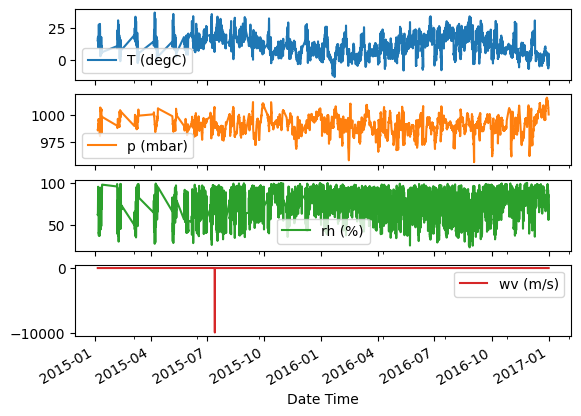

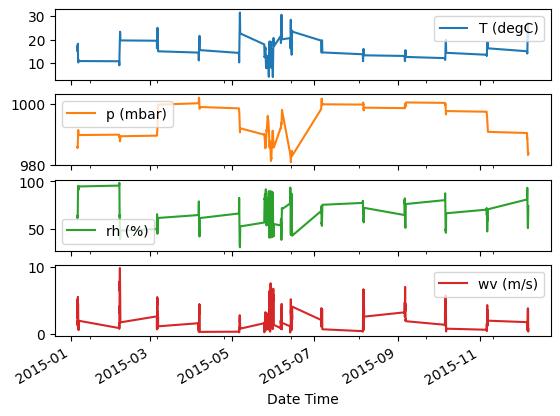

In [67]:
# We will plot the targets as with the training data

plot_cols = ['T (degC)', 'p (mbar)', 'rh (%)', 'wv (m/s)']
plot_features = df2[plot_cols]
plot_features.index = df2['Date Time']
_ = plot_features.plot(subplots=True)

plot_features = df2[plot_cols][:500]
plot_features.index = pd.DatetimeIndex(df2['Date Time'][:500])
_ = plot_features.plot(subplots=True)


Once again we see that the samples from 2015 look a bit strange. Also there is a strange anomaly in the wv (m/s), also in 2015. We will have to delete this whole year again

In [68]:
# Let's investigate deeper
df2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),14019.0,990.732392,8.220120,956.96,985.910,990.96,995.96,1015.29
T (degC),14019.0,11.301290,8.092519,-13.67,5.080,11.07,17.04,37.28
Tpot (K),14019.0,285.225804,8.224984,259.15,279.100,284.95,291.03,311.21
Tdew (degC),14019.0,6.576604,6.045940,-15.30,2.030,6.80,11.35,19.78
rh (%),14019.0,75.216103,16.357764,23.64,64.250,78.30,88.80,99.90
VPmax (mbar),14019.0,15.199599,8.514445,2.12,8.775,13.20,19.46,63.77
VPact (mbar),14019.0,10.481350,4.182481,1.85,7.080,9.89,13.45,23.10
VPdef (mbar),14019.0,4.718212,5.661257,0.01,1.090,2.60,6.07,46.01
wv (m/s),14019.0,-0.086451,146.298911,-9999.00,0.930,1.64,2.73,12.05
max. wv (m/s),14019.0,0.582371,168.955876,-9999.00,1.680,2.80,4.60,18.67


There are clearly two wrong values in the min column of the wv (m/s) and max. wv (m/s) variables. We will fix this:

In [69]:
# We replace the crazy values with a value of 0

wv = df2['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df2['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df2['wv (m/s)'].min()

C:\Users\usuario\AppData\Local\Temp\ipykernel_9152\2635357693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wv[bad_wv] = 0.0
C:\Users\usuario\AppData\Local\Temp\ipykernel_9152\2635357693.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_wv[bad_max_wv] = 0.0


0.0

In [70]:
# Let's investigate deeper
df2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),14019.0,990.732392,8.220120,956.96,985.910,990.96,995.96,1015.29
T (degC),14019.0,11.301290,8.092519,-13.67,5.080,11.07,17.04,37.28
Tpot (K),14019.0,285.225804,8.224984,259.15,279.100,284.95,291.03,311.21
Tdew (degC),14019.0,6.576604,6.045940,-15.30,2.030,6.80,11.35,19.78
rh (%),14019.0,75.216103,16.357764,23.64,64.250,78.30,88.80,99.90
VPmax (mbar),14019.0,15.199599,8.514445,2.12,8.775,13.20,19.46,63.77
VPact (mbar),14019.0,10.481350,4.182481,1.85,7.080,9.89,13.45,23.10
VPdef (mbar),14019.0,4.718212,5.661257,0.01,1.090,2.60,6.07,46.01
wv (m/s),14019.0,2.053288,1.544936,0.00,0.930,1.64,2.73,12.05
max. wv (m/s),14019.0,3.435356,2.364410,0.00,1.680,2.80,4.60,18.67


In [71]:
# We need to preprocess the wind variable that are expressed in radians as with the training set

wv = df2.pop('wv (m/s)')
max_wv = df2.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df2.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df2['Wx'] = wv*np.cos(wd_rad)
df2['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df2['max Wx'] = max_wv*np.cos(wd_rad)
df2['max Wy'] = max_wv*np.sin(wd_rad)

In [72]:
df2.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),Wx,Wy,max Wx,max Wy
0,2015-05-24 19:00:00,990.00,17.93,291.93,9.23,56.73,20.58,11.68,8.91,1.304147,0.891965,1.782884,1.219395
1,2015-05-24 20:00:00,989.86,16.92,290.93,9.52,61.65,19.31,11.90,7.40,0.214881,0.082012,0.560560,0.213945
2,2015-05-24 21:00:00,990.11,15.82,289.80,9.71,66.97,18.00,12.06,5.95,-0.080344,-0.247275,-0.160689,-0.494549
3,2015-05-24 22:00:00,990.01,15.02,289.01,9.50,69.53,17.10,11.89,5.21,-0.954782,-0.759468,-1.471303,-1.170328
4,2015-05-24 23:00:00,989.89,14.14,288.14,9.42,73.20,16.15,11.83,4.33,-1.126855,-0.880396,-1.544501,-1.206696


In [73]:
timestamp_s = df2['Date Time'].map(pd.Timestamp.timestamp)

In [74]:
day = 24*60*60
year = (365.2425)*day

df2['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df2['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df2['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df2['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

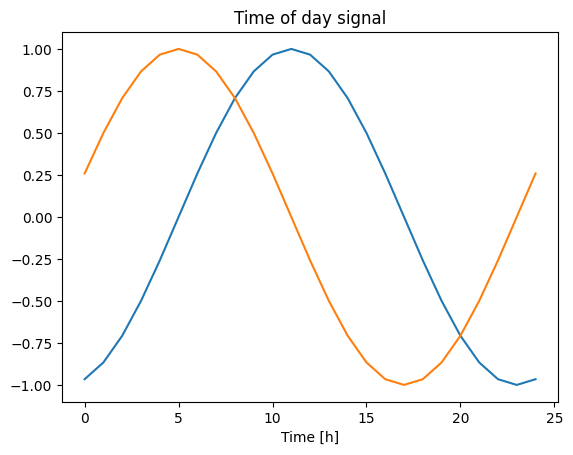

In [75]:
plt.plot(np.array(df2['Day sin'])[:25])
plt.plot(np.array(df2['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of year signal')

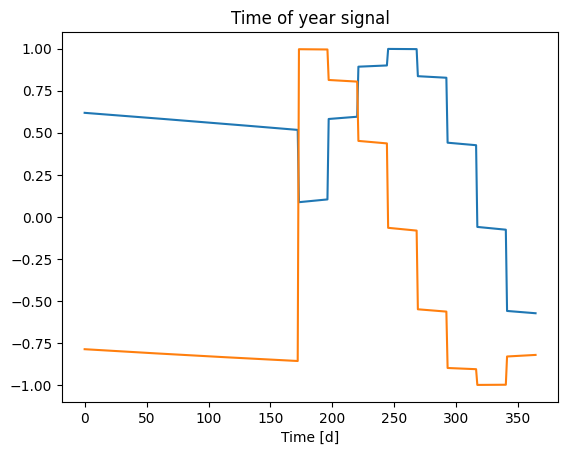

In [76]:
plt.plot(np.array(df2['Year sin'])[:365])
plt.plot(np.array(df2['Year cos'])[:365])
plt.xlabel('Time [d]')
plt.title('Time of year signal')

That looks wrong. Once again, the year 2015 is working against us. We will remove it.

In [77]:
df2.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,2015-05-24 19:00:00,990.00,17.93,291.93,9.23,56.73,20.58,11.68,8.91,1.304147,0.891965,1.782884,1.219395,-0.965926,0.258819,0.618216,-0.786008
1,2015-05-24 20:00:00,989.86,16.92,290.93,9.52,61.65,19.31,11.90,7.40,0.214881,0.082012,0.560560,0.213945,-0.866025,0.500000,0.617653,-0.786451
2,2015-05-24 21:00:00,990.11,15.82,289.80,9.71,66.97,18.00,12.06,5.95,-0.080344,-0.247275,-0.160689,-0.494549,-0.707107,0.707107,0.617089,-0.786893
3,2015-05-24 22:00:00,990.01,15.02,289.01,9.50,69.53,17.10,11.89,5.21,-0.954782,-0.759468,-1.471303,-1.170328,-0.500000,0.866025,0.616525,-0.787336
4,2015-05-24 23:00:00,989.89,14.14,288.14,9.42,73.20,16.15,11.83,4.33,-1.126855,-0.880396,-1.544501,-1.206696,-0.258819,0.965926,0.615960,-0.787777


In [78]:
df2 = df2[df2['Date Time'].dt.year != 2015] # Remove all rows whose year is 2015
df2.reset_index(drop=True, inplace=True) # Reset the index of the resulting dataframe

In [79]:
df2.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,2016-01-01 00:00:00,999.08,-0.01,273.22,-0.44,96.9,6.10,5.91,0.19,-1.132940,-0.249093,-1.992411,-0.438060,-1.407890e-12,1.000000,-0.002666,0.999996
1,2016-01-01 01:00:00,999.06,-0.05,273.18,-0.52,96.6,6.09,5.88,0.21,-0.345175,0.102246,-0.728703,0.215852,2.588190e-01,0.965926,-0.001950,0.999998
2,2016-01-01 02:00:00,999.00,-0.59,272.65,-0.99,97.1,5.85,5.68,0.17,-0.309603,0.163235,-0.530749,0.279832,5.000000e-01,0.866025,-0.001233,0.999999
3,2016-01-01 03:00:00,999.48,-1.83,271.37,-2.24,97.0,5.34,5.18,0.16,-0.373876,-0.067945,-0.629686,-0.114433,7.071068e-01,0.707107,-0.000516,1.000000
4,2016-01-01 04:00:00,999.65,-1.63,271.56,-1.96,97.6,5.42,5.29,0.13,-0.257776,0.033937,-0.555209,0.073095,8.660254e-01,0.500000,0.000201,1.000000


Text(0.5, 1.0, 'Time of year signal')

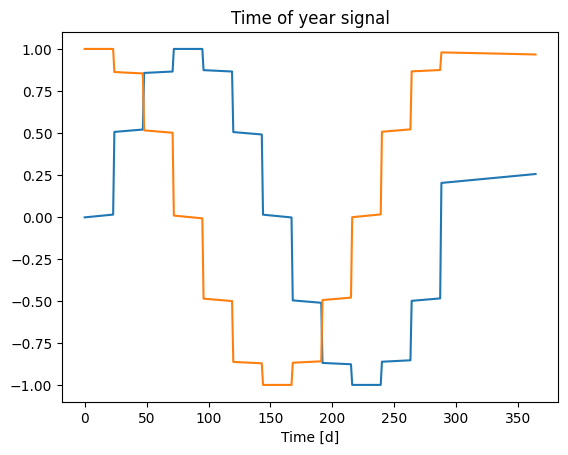

In [80]:
plt.plot(np.array(df2['Year sin'])[:365])
plt.plot(np.array(df2['Year cos'])[:365])
plt.xlabel('Time [d]')
plt.title('Time of year signal')

That looks much better. We may now proceed.

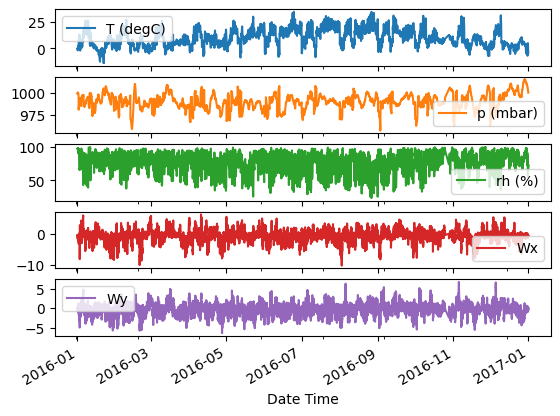

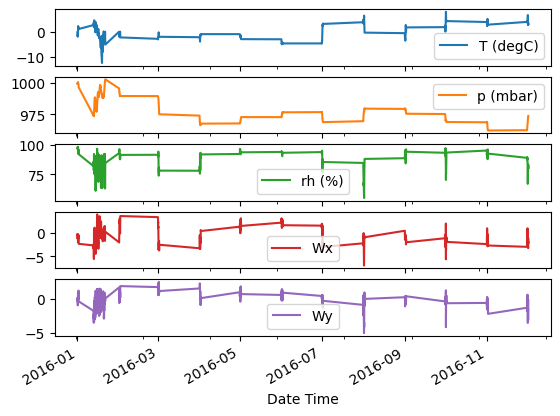

In [81]:
plot_cols = ['T (degC)', 'p (mbar)', 'rh (%)', 'Wx', 'Wy']
plot_features = df2[plot_cols]
plot_features.index = df2['Date Time']
_ = plot_features.plot(subplots=True)

plot_features = df2[plot_cols][:500]
plot_features.index = pd.DatetimeIndex(df2['Date Time'][:500])
_ = plot_features.plot(subplots=True)

That looks much better. We may proceed.

In [82]:
numeric_cols = df2.select_dtypes(include=[np.number]).columns
test_mean = df2[numeric_cols].mean(numeric_only=True)
test_std = df2[numeric_cols].std(numeric_only=True)

df2[numeric_cols] = (df2[numeric_cols] - test_mean) / test_std

In [83]:
df2.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,2016-01-01 00:00:00,1.025883,-1.215010,-1.287757,-0.931108,1.310194,-0.984703,-0.925270,-0.785769,-0.250515,0.092669,-0.309262,0.100154,0.000041,1.413911,-0.014694,1.411105
1,2016-01-01 01:00:00,1.023619,-1.219871,-1.292549,-0.943763,1.291557,-0.985945,-0.932440,-0.781896,0.167604,0.320749,0.120280,0.352602,0.366006,1.365720,-0.013676,1.411107
2,2016-01-01 02:00:00,1.016829,-1.285489,-1.356046,-1.018109,1.322619,-1.015752,-0.980240,-0.789642,0.186484,0.360343,0.187566,0.377302,0.707031,1.224433,-0.012659,1.411109
3,2016-01-01 03:00:00,1.071150,-1.436169,-1.509398,-1.215839,1.316406,-1.079091,-1.099742,-0.791579,0.152370,0.210266,0.153937,0.225093,0.999877,0.999677,-0.011641,1.411110
4,2016-01-01 04:00:00,1.090388,-1.411866,-1.486635,-1.171547,1.353681,-1.069155,-1.073452,-0.797389,0.213992,0.276405,0.179252,0.297489,1.224585,0.706769,-0.010624,1.411110


In [84]:
# Now we MinMax scale every column except the first column
scaler = MinMaxScaler(feature_range=(-1, 1)) # This is the scaler we will use to scale every column to values from 0 to 1
df2 = pd.DataFrame(scaler.fit_transform(df2.iloc[:, 1:]), columns=df2.columns[1:]) # Take all columns except the first

In [85]:
df2.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,0.444197,-0.430952,-0.431170,-0.151826,0.921322,-0.847363,-0.616981,-0.991234,0.096388,-0.060593,0.043580,-0.116223,-1.407980e-12,1.000000,-0.002666,0.999996
1,0.443511,-0.432618,-0.432788,-0.156393,0.913454,-0.847747,-0.619811,-0.990261,0.191060,-0.007101,0.142289,-0.056098,2.588190e-01,0.965926,-0.001950,0.999998
2,0.441454,-0.455114,-0.454215,-0.183219,0.926567,-0.856951,-0.638679,-0.992208,0.195335,0.002185,0.157751,-0.050215,5.000000e-01,0.866025,-0.001233,0.999999
3,0.457912,-0.506769,-0.505963,-0.254566,0.923944,-0.876510,-0.685849,-0.992695,0.187611,-0.033013,0.150023,-0.086466,7.071068e-01,0.707107,-0.000516,1.000000
4,0.463741,-0.498438,-0.498282,-0.238584,0.939680,-0.873442,-0.675472,-0.994156,0.201564,-0.017501,0.155841,-0.069224,8.660254e-01,0.500000,0.000201,1.000000


In [86]:
column_names = df2.columns.tolist()
print(column_names)

['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'Wx', 'Wy', 'max Wx', 'max Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']


In [87]:
def prepare_dataframe_for_lstm(df, n_steps):
   
    for i in range(1, n_steps+1):
        df[f'p (mbar)(t-{i})'] = df['p (mbar)'].shift(i)
    
    for i in range(1, n_steps+1):
        df[f'T (degC)(t-{i})'] = df['T (degC)'].shift(i)

    for i in range(1, n_steps+1):
        df[f'rh (%)(t-{i})'] = df['rh (%)'].shift(i)

    for i in range(1, n_steps+1):
        df[f'Tpot (K)(t-{i})'] = df['Tpot (K)'].shift(i)

    for i in range(1, n_steps+1):
        df[f'Tdew (degC)(t-{i})'] = df['Tdew (degC)'].shift(i)
        
    for i in range(1, n_steps+1):
        df[f'VPmax (mbar)(t-{i})'] = df['VPmax (mbar)'].shift(i)

    for i in range(1, n_steps+1):
        df[f'VPact (mbar)(t-{i})'] = df['VPact (mbar)'].shift(i)

    for i in range(1, n_steps+1):
        df[f'VPdef (mbar)(t-{i})'] = df['VPdef (mbar)'].shift(i)

    for i in range(1, n_steps+1):
        df[f'Wx(t-{i})'] = df['Wx'].shift(i)

    for i in range(1, n_steps+1):
        df[f'Wy(t-{i})'] = df['Wy'].shift(i)

    for i in range(1, n_steps+1):
        df[f'max Wx(t-{i})'] = df['max Wx'].shift(i)

    for i in range(1, n_steps+1):
        df[f'max Wy(t-{i})'] = df['max Wy'].shift(i)

    for i in range(1, n_steps+1):
        df[f'Day sin(t-{i})'] = df['Day sin'].shift(i)
        
    for i in range(1, n_steps+1):
        df[f'Day cos(t-{i})'] = df['Day cos'].shift(i)
        
    for i in range(1, n_steps+1):
        df[f'Year sin(t-{i})'] = df['Day sin'].shift(i)
        
    for i in range(1, n_steps+1):
        df[f'Year cos(t-{i})'] = df['Day cos'].shift(i)
   
    # Return the shifted dataframe
    return df

In [88]:
prepare_dataframe_for_lstm(df2, n_steps=lookback)

C:\Users\usuario\AppData\Local\Temp\ipykernel_9152\2134815107.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Day sin(t-{i})'] = df['Day sin'].shift(i)
C:\Users\usuario\AppData\Local\Temp\ipykernel_9152\2134815107.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Day sin(t-{i})'] = df['Day sin'].shift(i)
C:\Users\usuario\AppData\Local\Temp\ipykernel_9152\2134815107.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),Wx,Wy,...,Year sin(t-7),Year sin(t-8),Year cos(t-1),Year cos(t-2),Year cos(t-3),Year cos(t-4),Year cos(t-5),Year cos(t-6),Year cos(t-7),Year cos(t-8)
0,0.444197,-0.430952,-0.431170,-0.151826,0.921322,-0.847363,-0.616981,-0.991234,0.096388,-0.060593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.443511,-0.432618,-0.432788,-0.156393,0.913454,-0.847747,-0.619811,-0.990261,0.191060,-0.007101,...,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.441454,-0.455114,-0.454215,-0.183219,0.926567,-0.856951,-0.638679,-0.992208,0.195335,0.002185,...,NaN,NaN,0.965926,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,0.457912,-0.506769,-0.505963,-0.254566,0.923944,-0.876510,-0.685849,-0.992695,0.187611,-0.033013,...,NaN,NaN,0.866025,0.965926,1.000000,NaN,NaN,NaN,NaN,NaN
4,0.463741,-0.498438,-0.498282,-0.238584,0.939680,-0.873442,-0.675472,-0.994156,0.201564,-0.017501,...,NaN,NaN,0.707107,0.866025,0.965926,1.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8705,0.550489,-0.471360,-0.480089,-0.432648,0.268293,-0.863087,-0.788679,-0.923058,0.129772,-0.047034,...,-0.043619,0.216440,0.043619,-0.216440,-0.461749,-0.675590,-0.843391,-0.953717,-0.999048,-0.976296
8706,0.523744,-0.488856,-0.494239,-0.517123,0.118542,-0.869990,-0.830189,-0.909910,0.146472,-0.133245,...,-0.300706,-0.043619,0.300706,0.043619,-0.216440,-0.461749,-0.675590,-0.843391,-0.953717,-0.999048
8707,0.516544,-0.545095,-0.548413,-0.520548,0.291896,-0.889933,-0.831132,-0.934746,0.153045,0.016600,...,-0.537300,-0.300706,0.537300,0.300706,0.043619,-0.216440,-0.461749,-0.675590,-0.843391,-0.953717
8708,0.498028,-0.550927,-0.552456,-0.534817,0.276161,-0.892234,-0.837736,-0.933772,0.198818,-0.054515,...,-0.737277,-0.537300,0.737277,0.537300,0.300706,0.043619,-0.216440,-0.461749,-0.675590,-0.843391


In [89]:
# Define a list of timepoints to group by
timepoints = [f't-{i}' for i in range(lookback, 0, -1)]

# Group the shifted columns by timepoint
all_shifted_cols = []
for timepoint in timepoints:
    columns = [f'{col}({timepoint})' for col in ['p (mbar)', 'T (degC)', 'rh (%)', 'Wx', 'Wy', 
                                                 'Tpot (K)', 'Tdew (degC)', 
                                                 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 
                                                 'max Wx', 'max Wy', 'Day sin', 
                                                 'Day cos', 'Year sin', 'Year cos' ]] #'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)'
    all_shifted_cols.extend(columns)
    
# Concatenate the target columns and the grouped columns
target_cols = ['p (mbar)', 'T (degC)', 'rh (%)', 'Wx', 'Wy']
feature_cols = ['Tpot (K)', 'Tdew (degC)', 
                                                 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 
                                                 'max Wx', 'max Wy', 'Day sin', 
                                                 'Day cos', 'Year sin', 'Year cos'] # 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)'
all_cols = target_cols + feature_cols + all_shifted_cols

In [90]:
# Let us take a look at the final variable 'all_cols'
all_cols

['p (mbar)',
 'T (degC)',
 'rh (%)',
 'Wx',
 'Wy',
 'Tpot (K)',
 'Tdew (degC)',
 'VPmax (mbar)',
 'VPact (mbar)',
 'VPdef (mbar)',
 'max Wx',
 'max Wy',
 'Day sin',
 'Day cos',
 'Year sin',
 'Year cos',
 'p (mbar)(t-8)',
 'T (degC)(t-8)',
 'rh (%)(t-8)',
 'Wx(t-8)',
 'Wy(t-8)',
 'Tpot (K)(t-8)',
 'Tdew (degC)(t-8)',
 'VPmax (mbar)(t-8)',
 'VPact (mbar)(t-8)',
 'VPdef (mbar)(t-8)',
 'max Wx(t-8)',
 'max Wy(t-8)',
 'Day sin(t-8)',
 'Day cos(t-8)',
 'Year sin(t-8)',
 'Year cos(t-8)',
 'p (mbar)(t-7)',
 'T (degC)(t-7)',
 'rh (%)(t-7)',
 'Wx(t-7)',
 'Wy(t-7)',
 'Tpot (K)(t-7)',
 'Tdew (degC)(t-7)',
 'VPmax (mbar)(t-7)',
 'VPact (mbar)(t-7)',
 'VPdef (mbar)(t-7)',
 'max Wx(t-7)',
 'max Wy(t-7)',
 'Day sin(t-7)',
 'Day cos(t-7)',
 'Year sin(t-7)',
 'Year cos(t-7)',
 'p (mbar)(t-6)',
 'T (degC)(t-6)',
 'rh (%)(t-6)',
 'Wx(t-6)',
 'Wy(t-6)',
 'Tpot (K)(t-6)',
 'Tdew (degC)(t-6)',
 'VPmax (mbar)(t-6)',
 'VPact (mbar)(t-6)',
 'VPdef (mbar)(t-6)',
 'max Wx(t-6)',
 'max Wy(t-6)',
 'Day sin(t-6)',
 

In [91]:
# First we udpate the df
df2 = df2[all_cols]

In [92]:
df2.head()

,p (mbar),T (degC),rh (%),Wx,Wy,Tpot (K),Tdew (degC),VPmax (mbar),VPact (mbar),VPdef (mbar),...,Tdew (degC)(t-1),VPmax (mbar)(t-1),VPact (mbar)(t-1),VPdef (mbar)(t-1),max Wx(t-1),max Wy(t-1),Day sin(t-1),Day cos(t-1),Year sin(t-1),Year cos(t-1)
0,0.444197,-0.430952,0.921322,0.096388,-0.060593,-0.431170,-0.151826,-0.847363,-0.616981,-0.991234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.443511,-0.432618,0.913454,0.191060,-0.007101,-0.432788,-0.156393,-0.847747,-0.619811,-0.990261,...,-0.151826,-0.847363,-0.616981,-0.991234,0.043580,-0.116223,-1.407980e-12,1.000000,-1.407980e-12,1.000000
2,0.441454,-0.455114,0.926567,0.195335,0.002185,-0.454215,-0.183219,-0.856951,-0.638679,-0.992208,...,-0.156393,-0.847747,-0.619811,-0.990261,0.142289,-0.056098,2.588190e-01,0.965926,2.588190e-01,0.965926
3,0.457912,-0.506769,0.923944,0.187611,-0.033013,-0.505963,-0.254566,-0.876510,-0.685849,-0.992695,...,-0.183219,-0.856951,-0.638679,-0.992208,0.157751,-0.050215,5.000000e-01,0.866025,5.000000e-01,0.866025
4,0.463741,-0.498438,0.939680,0.201564,-0.017501,-0.498282,-0.238584,-0.873442,-0.675472,-0.994156,...,-0.254566,-0.876510,-0.685849,-0.992695,0.150023,-0.086466,7.071068e-01,0.707107,7.071068e-01,0.707107


In [93]:
print(df2.columns[:60])

Index(['p (mbar)', 'T (degC)', 'rh (%)', 'Wx', 'Wy', 'Tpot (K)', 'Tdew (degC)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'max Wx', 'max Wy',
       'Day sin', 'Day cos', 'Year sin', 'Year cos', 'p (mbar)(t-8)',
       'T (degC)(t-8)', 'rh (%)(t-8)', 'Wx(t-8)', 'Wy(t-8)', 'Tpot (K)(t-8)',
       'Tdew (degC)(t-8)', 'VPmax (mbar)(t-8)', 'VPact (mbar)(t-8)',
       'VPdef (mbar)(t-8)', 'max Wx(t-8)', 'max Wy(t-8)', 'Day sin(t-8)',
       'Day cos(t-8)', 'Year sin(t-8)', 'Year cos(t-8)', 'p (mbar)(t-7)',
       'T (degC)(t-7)', 'rh (%)(t-7)', 'Wx(t-7)', 'Wy(t-7)', 'Tpot (K)(t-7)',
       'Tdew (degC)(t-7)', 'VPmax (mbar)(t-7)', 'VPact (mbar)(t-7)',
       'VPdef (mbar)(t-7)', 'max Wx(t-7)', 'max Wy(t-7)', 'Day sin(t-7)',
       'Day cos(t-7)', 'Year sin(t-7)', 'Year cos(t-7)', 'p (mbar)(t-6)',
       'T (degC)(t-6)', 'rh (%)(t-6)', 'Wx(t-6)', 'Wy(t-6)', 'Tpot (K)(t-6)',
       'Tdew (degC)(t-6)', 'VPmax (mbar)(t-6)', 'VPact (mbar)(t-6)',
       'VPdef (mbar)(t-6)', 'max Wx(t-

In [94]:
shifted_df2 = df2.drop(df2.columns[5:16], axis=1) # We delete the custom features at timpoint t

In [95]:
shifted_df2.head(9)

,p (mbar),T (degC),rh (%),Wx,Wy,p (mbar)(t-8),T (degC)(t-8),rh (%)(t-8),Wx(t-8),Wy(t-8),...,Tdew (degC)(t-1),VPmax (mbar)(t-1),VPact (mbar)(t-1),VPdef (mbar)(t-1),max Wx(t-1),max Wy(t-1),Day sin(t-1),Day cos(t-1),Year sin(t-1),Year cos(t-1)
0,0.444197,-0.430952,0.921322,0.096388,-0.060593,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.443511,-0.432618,0.913454,0.191060,-0.007101,NaN,NaN,NaN,NaN,NaN,...,-0.151826,-0.847363,-0.616981,-0.991234,0.043580,-0.116223,-1.407980e-12,1.000000e+00,-1.407980e-12,1.000000e+00
2,0.441454,-0.455114,0.926567,0.195335,0.002185,NaN,NaN,NaN,NaN,NaN,...,-0.156393,-0.847747,-0.619811,-0.990261,0.142289,-0.056098,2.588190e-01,9.659258e-01,2.588190e-01,9.659258e-01
3,0.457912,-0.506769,0.923944,0.187611,-0.033013,NaN,NaN,NaN,NaN,NaN,...,-0.183219,-0.856951,-0.638679,-0.992208,0.157751,-0.050215,5.000000e-01,8.660254e-01,5.000000e-01,8.660254e-01
4,0.463741,-0.498438,0.939680,0.201564,-0.017501,NaN,NaN,NaN,NaN,NaN,...,-0.254566,-0.876510,-0.685849,-0.992695,0.150023,-0.086466,7.071068e-01,7.071068e-01,7.071068e-01,7.071068e-01
5,0.464769,-0.507186,0.950170,0.126132,-0.036362,NaN,NaN,NaN,NaN,NaN,...,-0.238584,-0.873442,-0.675472,-0.994156,0.155841,-0.069224,8.660254e-01,5.000000e-01,8.660254e-01,5.000000e-01
6,0.454140,-0.506353,0.950170,0.147457,-0.014563,NaN,NaN,NaN,NaN,NaN,...,-0.247146,-0.876510,-0.681132,-0.995130,0.091968,-0.088767,9.659258e-01,2.588190e-01,9.659258e-01,2.588190e-01
7,0.463741,-0.489690,0.958038,0.123739,-0.171007,NaN,NaN,NaN,NaN,NaN,...,-0.246005,-0.876510,-0.680189,-0.995130,0.093277,-0.066569,1.000000e+00,3.971375e-12,1.000000e+00,3.971375e-12
8,0.465112,-0.470944,0.952793,0.120035,-0.066790,0.444197,-0.430952,0.921322,0.096388,-0.060593,...,-0.220890,-0.870374,-0.664151,-0.996104,0.088612,-0.216043,9.659258e-01,-2.588190e-01,9.659258e-01,-2.588190e-01


In [96]:
shifted_df2 = shifted_df2.dropna()

In [97]:
shifted_df2.head(9)

,p (mbar),T (degC),rh (%),Wx,Wy,p (mbar)(t-8),T (degC)(t-8),rh (%)(t-8),Wx(t-8),Wy(t-8),...,Tdew (degC)(t-1),VPmax (mbar)(t-1),VPact (mbar)(t-1),VPdef (mbar)(t-1),max Wx(t-1),max Wy(t-1),Day sin(t-1),Day cos(t-1),Year sin(t-1),Year cos(t-1)
8,0.465112,-0.470944,0.952793,0.120035,-0.066790,0.444197,-0.430952,0.921322,0.096388,-0.060593,...,-0.220890,-0.870374,-0.664151,-0.996104,0.088612,-0.216043,9.659258e-01,-0.258819,9.659258e-01,-0.258819
9,0.477799,-0.490523,0.955416,0.004206,-0.021658,0.443511,-0.432618,0.913454,0.191060,-0.007101,...,-0.196918,-0.863087,-0.648113,-0.995130,0.079821,-0.119448,8.660254e-01,-0.500000,8.660254e-01,-0.500000
10,0.483971,-0.453447,0.958038,0.108342,-0.084333,0.441454,-0.455114,0.926567,0.195335,0.002185,...,-0.222603,-0.870374,-0.665094,-0.995617,-0.022625,-0.075033,7.071068e-01,-0.707107,7.071068e-01,-0.707107
11,0.491171,-0.463862,0.947548,-0.011190,0.107134,0.457912,-0.506769,0.923944,0.187611,-0.033013,...,-0.171804,-0.856184,-0.630189,-0.995617,0.059576,-0.140359,5.000000e-01,-0.866025,5.000000e-01,-0.866025
12,0.471970,-0.431785,0.947548,0.121641,0.017620,0.463741,-0.498438,0.939680,0.201564,-0.017501,...,-0.188927,-0.860403,-0.642453,-0.994643,-0.069379,0.056958,2.588190e-01,-0.965926,2.588190e-01,-0.965926
13,0.455512,-0.366799,0.887228,0.147575,0.034328,0.464769,-0.507186,0.950170,0.126132,-0.036362,...,-0.144977,-0.847747,-0.612264,-0.994156,0.055046,-0.027284,6.534489e-12,-1.000000,6.534489e-12,-1.000000
14,0.440082,-0.328890,0.897718,0.132310,0.020068,0.454140,-0.506353,0.950170,0.147457,-0.014563,...,-0.074772,-0.819751,-0.559434,-0.985878,0.102564,-0.015710,-2.588190e-01,-0.965926,-2.588190e-01,-0.965926
15,0.445911,-0.337638,0.876737,0.153612,-0.042831,0.463741,-0.489690,0.958038,0.123739,-0.171007,...,-0.019977,-0.802109,-0.515094,-0.986365,0.070395,-0.024915,-5.000000e-01,-0.866025,-5.000000e-01,-0.866025
16,0.445568,-0.339304,0.803304,0.158196,-0.016412,0.465112,-0.470944,0.952793,0.120035,-0.066790,...,-0.038813,-0.806328,-0.530189,-0.983930,0.098137,-0.099934,-7.071068e-01,-0.707107,-7.071068e-01,-0.707107


In [98]:
# We convert to numpy and print
shifted_df2_as_np = shifted_df2.to_numpy()
print(shifted_df2_as_np)

[[ 0.46511229 -0.47094355  0.95279308 ... -0.25881905  0.96592583
  -0.25881905]
 [ 0.47779873 -0.49052281  0.95541568 ... -0.5         0.8660254
  -0.5       ]
 [ 0.48397051 -0.4534472   0.95803829 ... -0.70710678  0.70710678
  -0.70710678]
 ...
 [ 0.5165438  -0.54509477  0.29189614 ...  0.53729961 -0.84339145
   0.53729961]
 [ 0.49802846 -0.55092689  0.2761605  ...  0.73727734 -0.67559021
   0.73727734]
 [ 0.47951312 -0.5942512   0.28402832 ...  0.88701083 -0.46174861
   0.88701083]]


In [99]:
print(shifted_df2_as_np.shape)

(8702, 133)


In [100]:

X_eval = shifted_df2_as_np[:, 5:]
y_eval = shifted_df2_as_np[:, :5]
print(X_eval.shape, y_eval.shape)

(8702, 128) (8702, 5)


In [101]:
# Because this is the LSTM model, we WILL reshape the the X values

X_eval = X_eval.reshape(-1, lookback, 16)

print(X_eval.shape)
print(y_eval.shape)

(8702, 8, 16)
(8702, 5)


In [102]:
# Pytorch only deals with tensors, so we need to convert these last np arrays into torch floats:
X_eval = torch.tensor(X_eval).float()
y_eval = torch.tensor(y_eval).float()

print(X_eval.shape, y_eval.shape) #, y_train.shape, y_test.shape) # Inspect the shape once again


torch.Size([8702, 8, 16]) torch.Size([8702, 5])


In [103]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset): # Nothing fancy here, just making sure we can access length and individual items
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
eval_dataset = TimeSeriesDataset(X_eval, y_eval)

In [104]:
from torch.utils.data import DataLoader

batch_size = batch_size # We will try batch_size values of 64 and 32

eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True) 

In [105]:
# One last sanity check. Let us make sure we can retrieve batches and that they have the right size: 
for _, batch in enumerate(eval_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([64, 8, 16]) torch.Size([64, 5])


In [106]:
def evaluate_model(model, dataloader, loss_function, num_epochs):
    model.eval()
    with torch.no_grad():
        for epoch in range(num_epochs):
            running_loss = 0.0
            running_correct = 0.0
            running_total = 0.0
            
            running_mae = np.zeros((5,))
            running_r2 = np.zeros((5,))
            running_counts = np.zeros((5,))
            
            for batch_index, batch in enumerate(dataloader):
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)

                output = model(x_batch)
                loss = loss_function(output, y_batch)
                running_loss += loss.item()
                running_total += y_batch.size(0)

                y_pred = output.detach().cpu().numpy()
                y_true = y_batch.detach().cpu().numpy()
                
                for i in range(5):
                    running_mae[i] += mean_absolute_error(y_true[:, i], y_pred[:, i])
                    running_r2[i] += r2_score(y_true[:, i], y_pred[:, i])
                    running_counts[i] += 1
                    
                r2 = r2_score(y_true, y_pred)
                running_correct += r2*y_batch.size(0)

            avg_loss_across_batches = running_loss / len(dataloader)
            avg_r2_across_batches = running_correct / running_total
            avg_mae_across_targets = running_mae / running_counts
            avg_r2_across_targets = running_r2 / running_counts

            test_losses.append(avg_loss_across_batches)
            test_r2s.append(avg_r2_across_batches)

            print('Epoch {0}, Test MAE Loss: {1:.3f}'.format(epoch+1, avg_loss_across_batches))
            print('Epoch {0}, Test R2 Score: {1:.3f}'.format(epoch+1, avg_r2_across_batches))
            print('Test individual target MAEs:', avg_mae_across_targets)
            print('Test individual target R2s:', avg_r2_across_targets)
            print('***************************************************')

In [107]:
### We're ready to evaluate ! ###

loss_function = nn.L1Loss() 
num_epochs = 50

test_losses = []
test_r2s = []

evaluate_model(model=model, dataloader = eval_loader, loss_function = loss_function, num_epochs = num_epochs)

Epoch 1, Test MAE Loss: 0.079
Epoch 1, Test R2 Score: 0.840
Test individual target MAEs: [0.05957392 0.0429847  0.10686335 0.08787337 0.09677647]
Test individual target R2s: [0.95064908 0.97758833 0.89301135 0.70033816 0.68013524]
***************************************************
Epoch 2, Test MAE Loss: 0.079
Epoch 2, Test R2 Score: 0.842
Test individual target MAEs: [0.05957448 0.04298416 0.1068669  0.08787606 0.0967809 ]
Test individual target R2s: [0.95078331 0.97772808 0.894182   0.70426603 0.68151208]
***************************************************
Epoch 3, Test MAE Loss: 0.079
Epoch 3, Test R2 Score: 0.840
Test individual target MAEs: [0.05957424 0.04298345 0.10685984 0.0878753  0.09677896]
Test individual target R2s: [0.95108381 0.97779304 0.89229702 0.70008399 0.679613  ]
***************************************************
Epoch 4, Test MAE Loss: 0.079
Epoch 4, Test R2 Score: 0.841
Test individual target MAEs: [0.05957522 0.04298491 0.10686057 0.08787316 0.09677644]
Test 

Epoch 30, Test MAE Loss: 0.079
Epoch 30, Test R2 Score: 0.839
Test individual target MAEs: [0.05957409 0.04298454 0.10686302 0.08787468 0.096775  ]
Test individual target R2s: [0.95070431 0.97761776 0.89276324 0.69620401 0.67719506]
***************************************************
Epoch 31, Test MAE Loss: 0.079
Epoch 31, Test R2 Score: 0.840
Test individual target MAEs: [0.05957388 0.04298427 0.10686455 0.08787856 0.09677771]
Test individual target R2s: [0.95082793 0.97753512 0.89239452 0.6972891  0.67989933]
***************************************************
Epoch 32, Test MAE Loss: 0.079
Epoch 32, Test R2 Score: 0.840
Test individual target MAEs: [0.05957563 0.04298426 0.10686245 0.08787647 0.09677793]
Test individual target R2s: [0.95068085 0.9776634  0.89259622 0.69871765 0.67810934]
***************************************************
Epoch 33, Test MAE Loss: 0.079
Epoch 33, Test R2 Score: 0.840
Test individual target MAEs: [0.05957497 0.04298398 0.10686683 0.08787224 0.0967779